In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, walk, listdir
from os.path import isfile
from statistics import fmean
import re
from tqdm import tqdm

# Constants

In [226]:
RUNTIME_SECONDS = 3600

DIR_Classic = "../bench_data/classic/"
DIR_Modified = "../bench_data/modified/"

REGEX_NODES = r"\d+_nodes"
REGEX_VERSION = r"(modified)|(classic)"
REGEX_DURATION = r"\d+_minutes"
REGEX_RUN = r"run_\d+"
REGEX_PROBABILITY = r"(even)|(biased)"

COLOR_PALETTE = ['#0072B2', '#E1812C', "#009E73", "#CC79A7", "#56B4E9", "E69F00", "CC79A7"]

# Utility Functions

In [117]:
def find_all_csvs(rootpath : str) -> list[str]:
    csvs = []
    for root, dirs, files in walk(rootpath):
        for dir in dirs:
            dir_path = path.join(root, dir)
            csvs = csvs + [path.normpath(path.abspath(path.join(root, dir, file))) for file in listdir(dir_path) if file.endswith('csv')]
    return csvs

def find_all_csvs_and_join(rootpaths : list[str]) -> list[str]:
    csvs = []
    for path in rootpaths:
        csvs = csvs + find_all_csvs(path)
    return csvs

In [118]:
FILES = find_all_csvs("..\\bench_data")

In [119]:
def open_csv(path : str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.leaderId != -1] # Remove the initial dummy entries
    return df

In [120]:
def find_node_count(df : pd.DataFrame) -> int:
    return len(df["serverId"].unique())

In [121]:
def find_quorum_size(df : pd.DataFrame) -> int:
    return find_node_count(df) // 2 + 1

In [122]:
def get_node_count(file : str) -> int:
    num, _ = re.search(REGEX_NODES, file).group().split("_", maxsplit=1)
    return int(num)

def get_duration_minutes(file : str) -> int:
    num, _ = re.search(REGEX_DURATION, file).group().split("_", maxsplit=1)
    return int(num)

def get_algorithm_type(file : str) -> str:
    return re.search(REGEX_VERSION, file).group()

def get_run_id(file : str) -> str:
    return re.search(REGEX_RUN, file).group()

def get_probability_type(file : str) -> str:
    return re.search(REGEX_PROBABILITY, file).group()

# Work per Leader

## Committed entries

In [123]:
def plot_leader_commit_counts(df : pd.DataFrame, title=None):
    leaders = df["leaderId"].value_counts()
    leaders = leaders / len(df)
    # plt.bar(leaders.index, leaders)
    sns.barplot(leaders)
    plt.ylim(0,1)
    if not title is None:
        plt.title(title)
    plt.show()

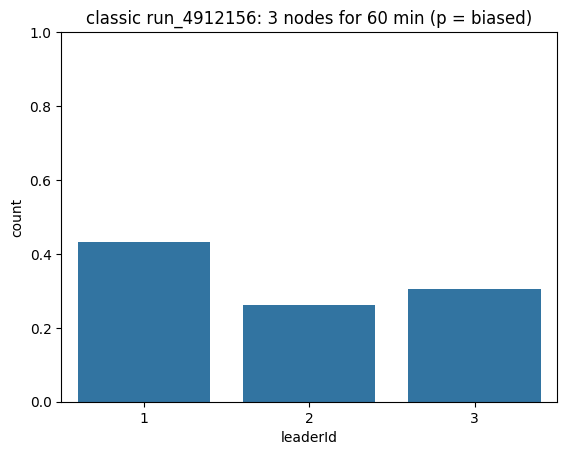

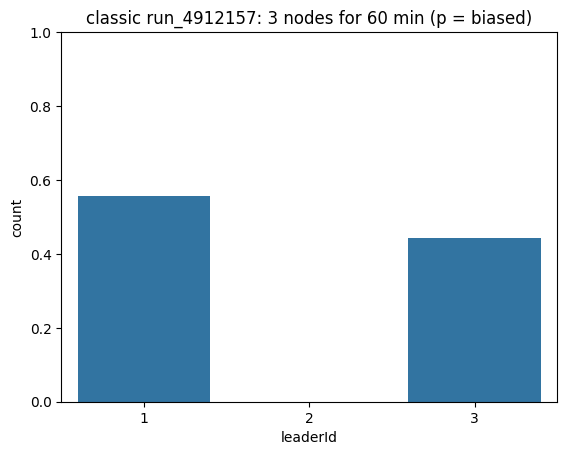

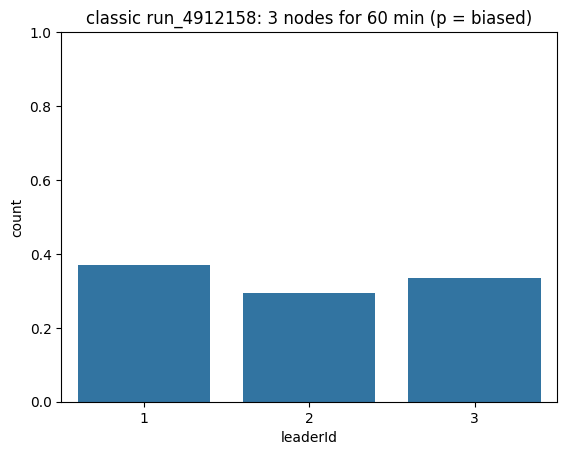

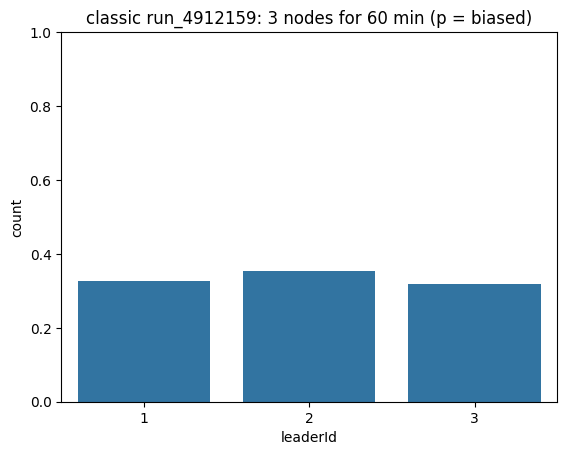

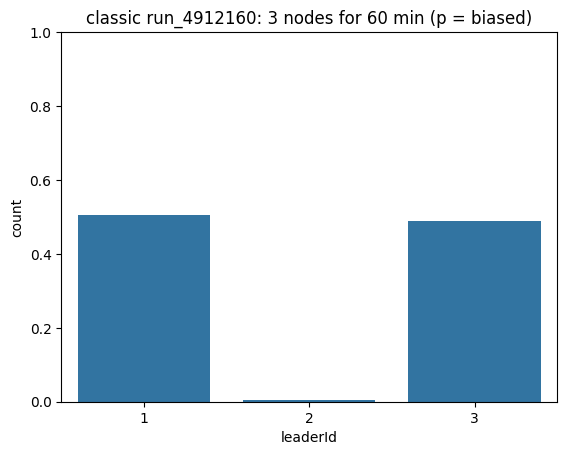

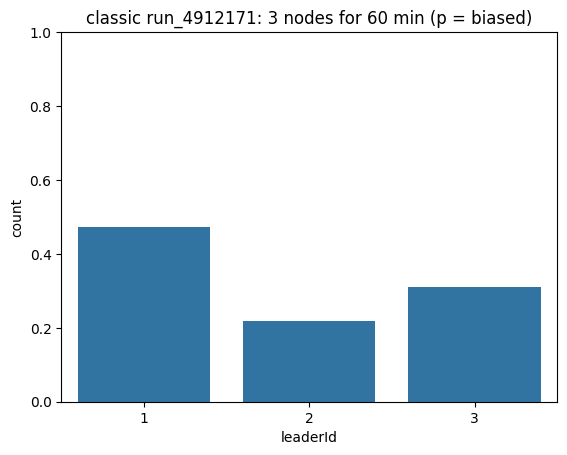

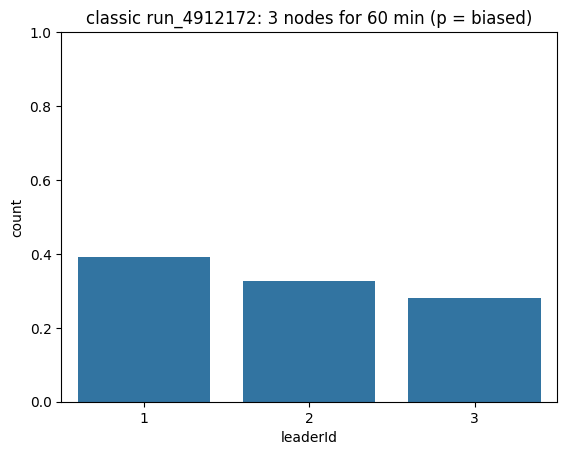

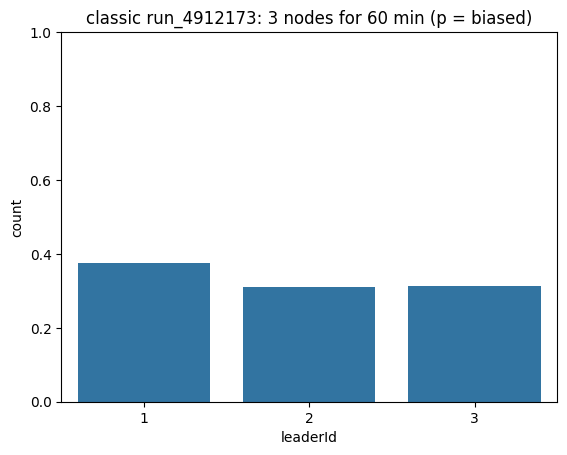

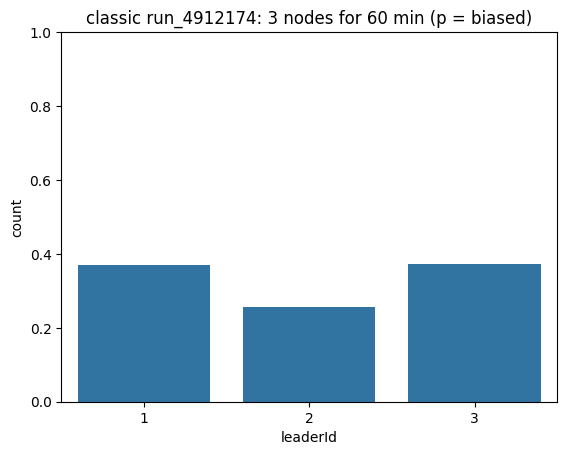

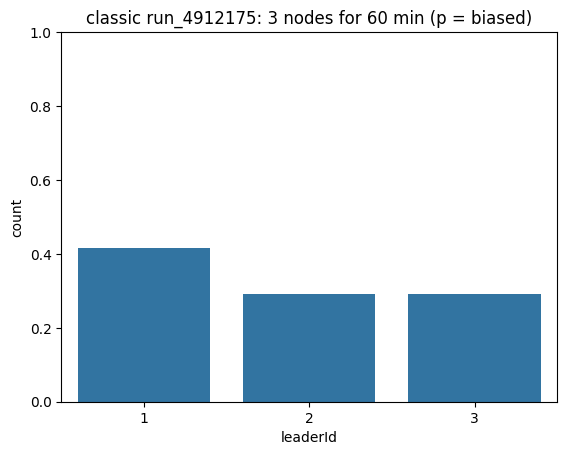

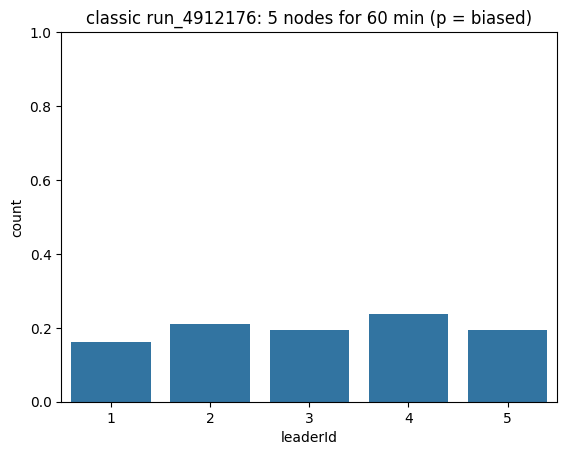

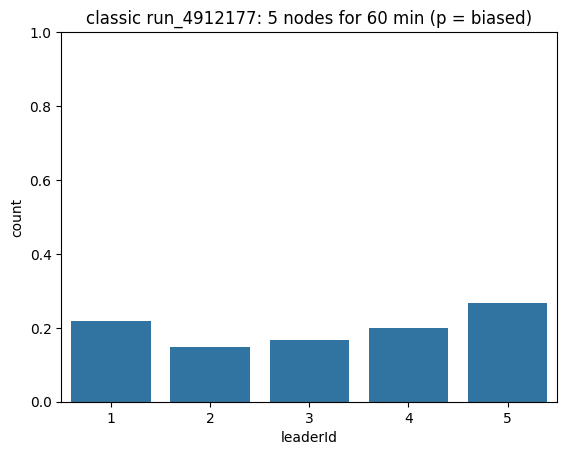

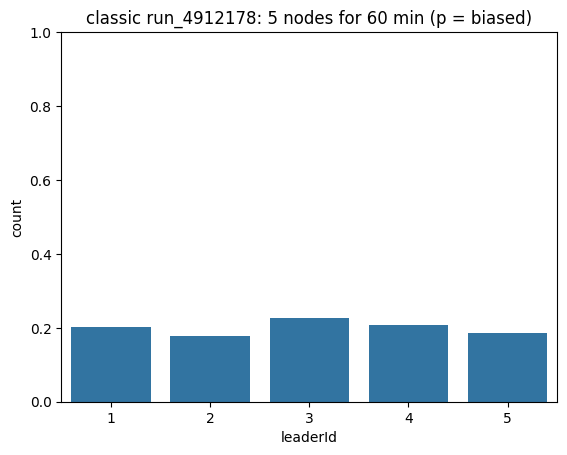

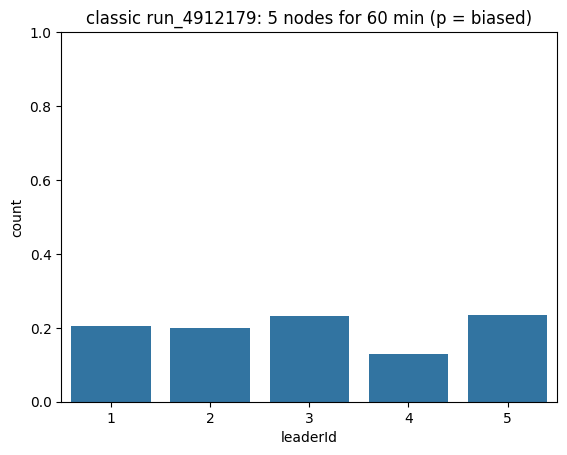

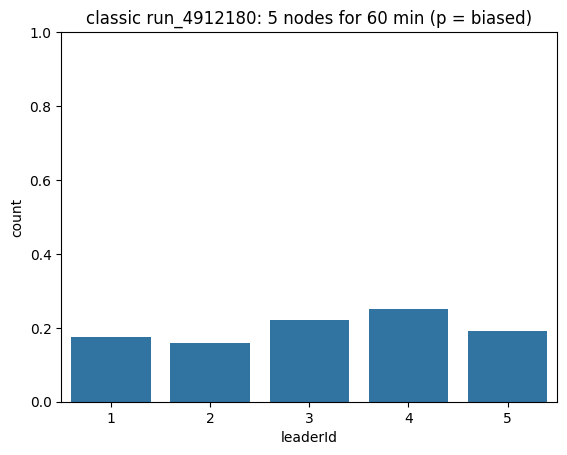

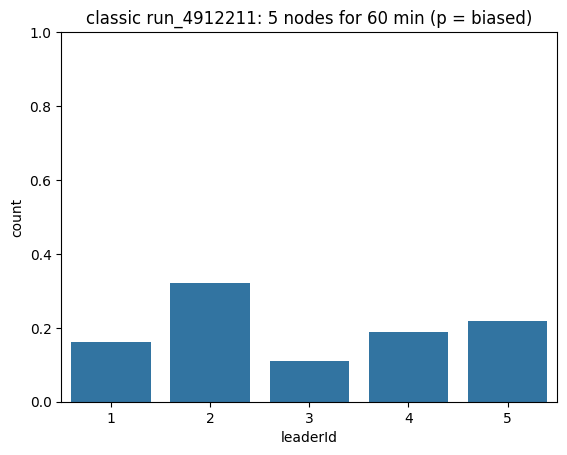

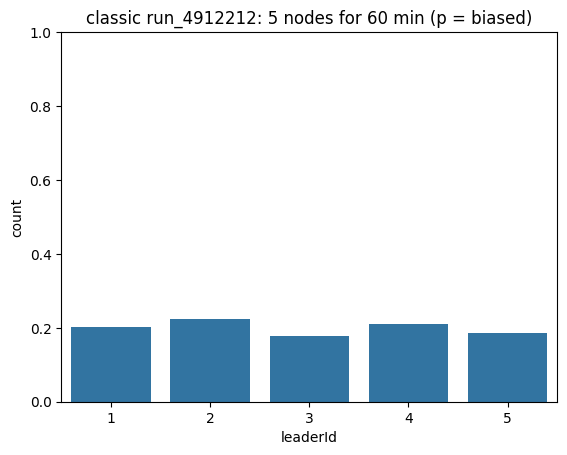

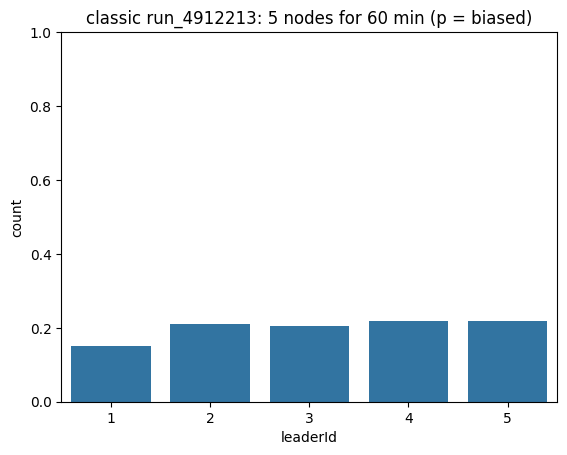

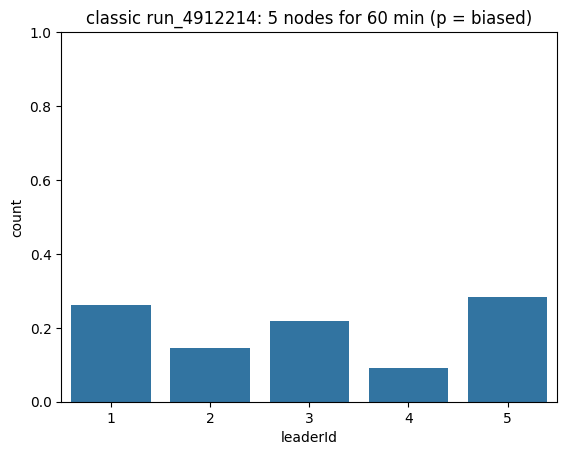

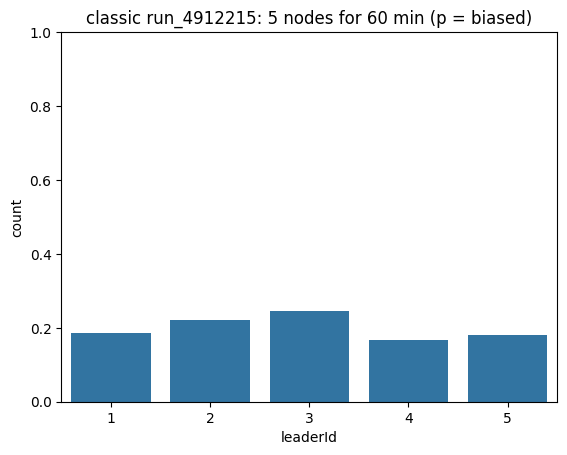

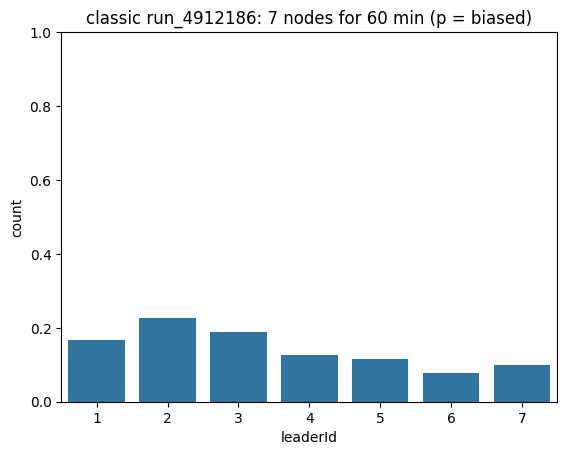

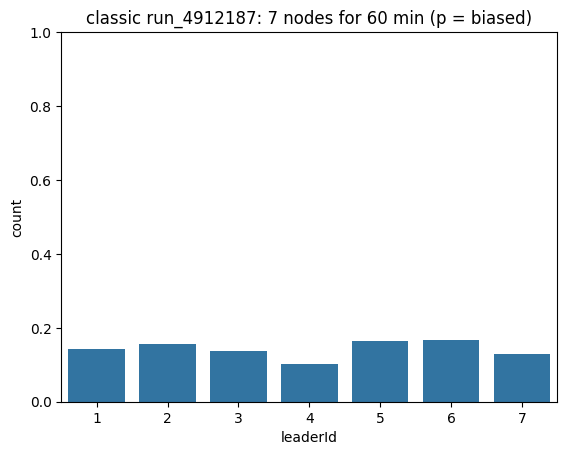

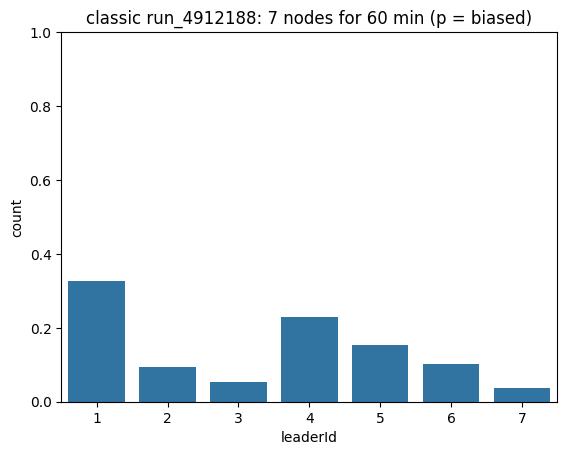

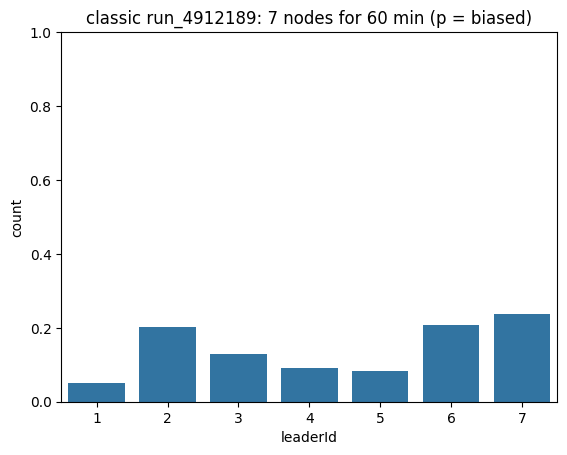

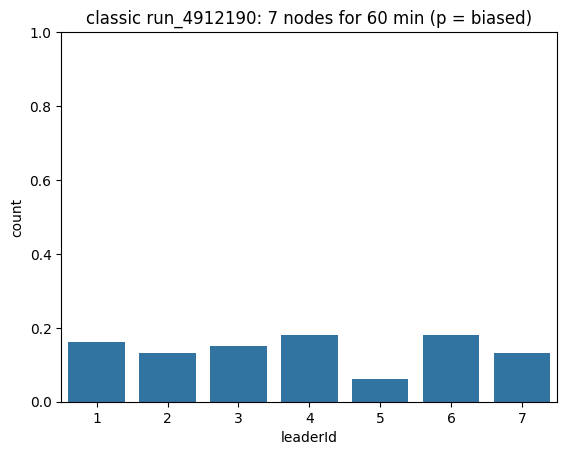

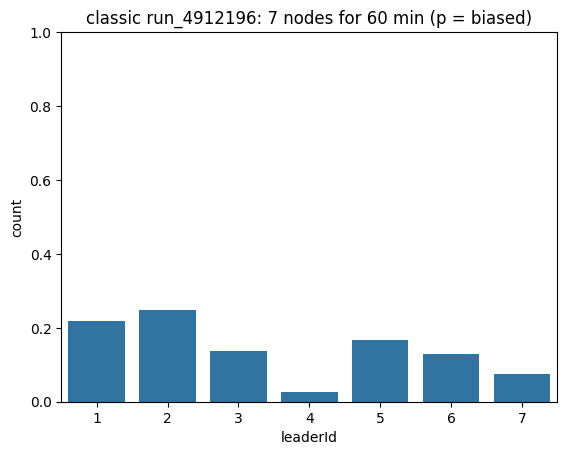

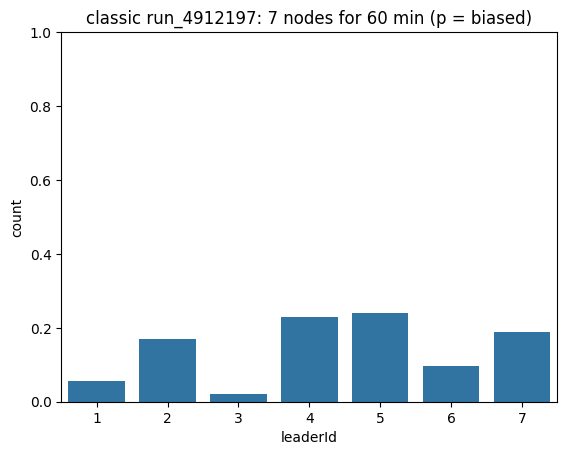

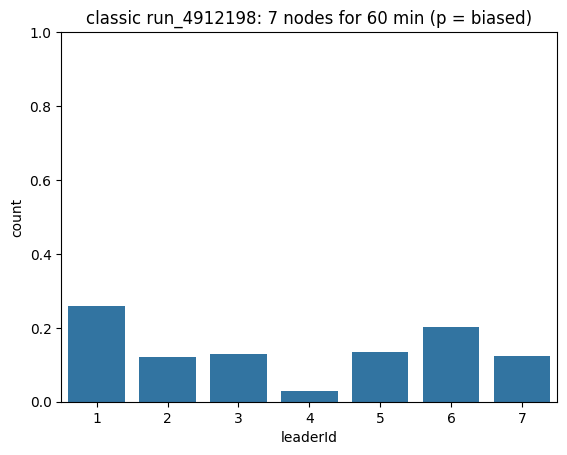

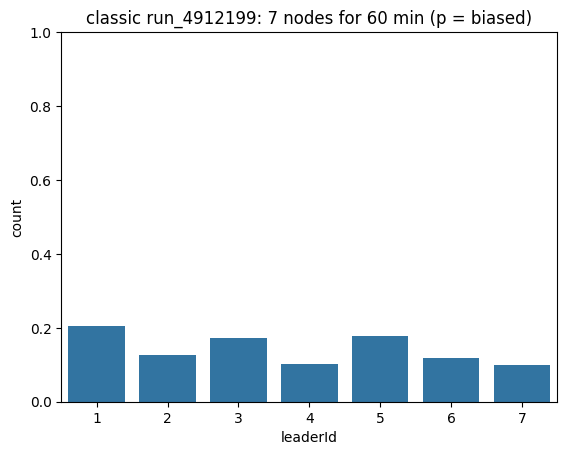

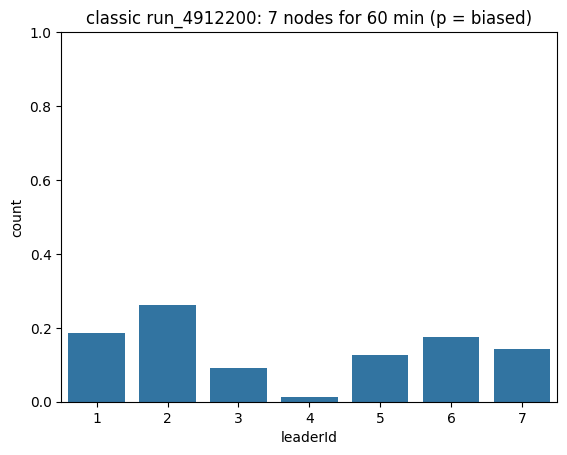

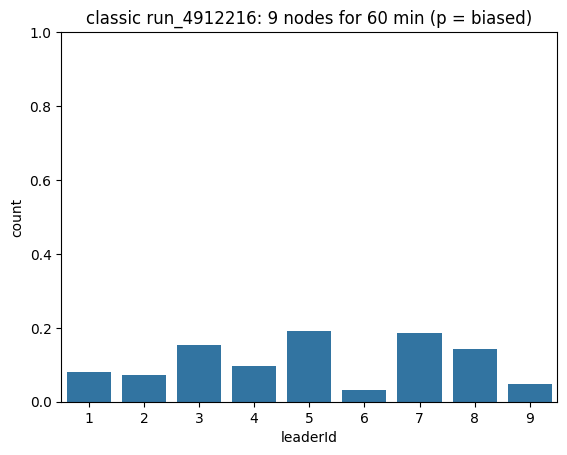

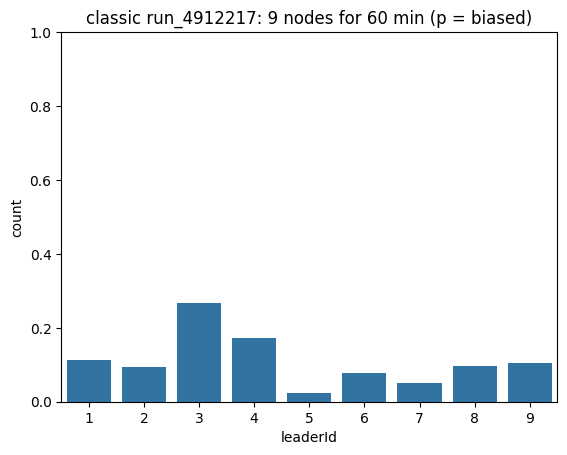

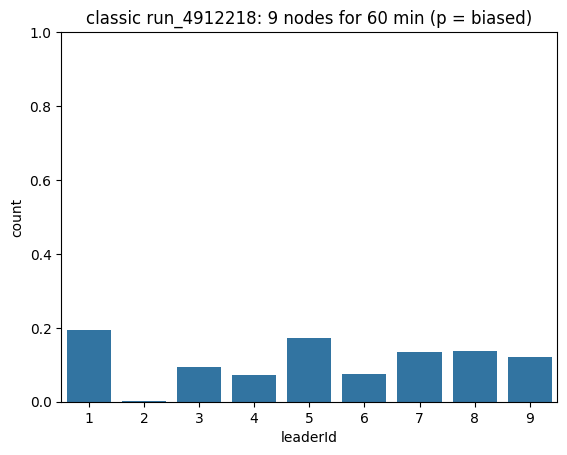

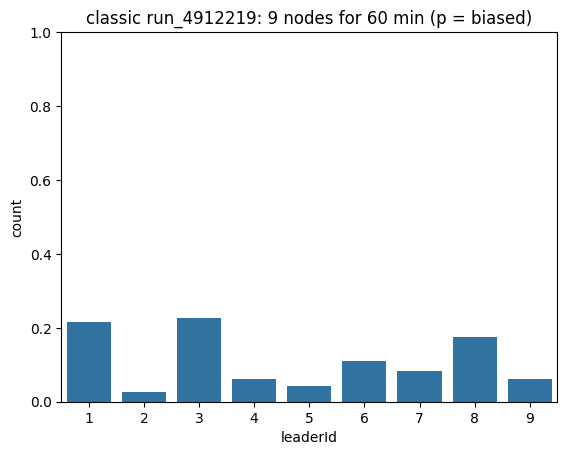

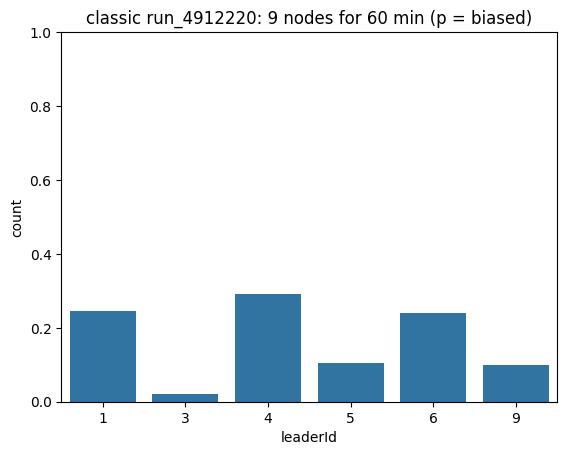

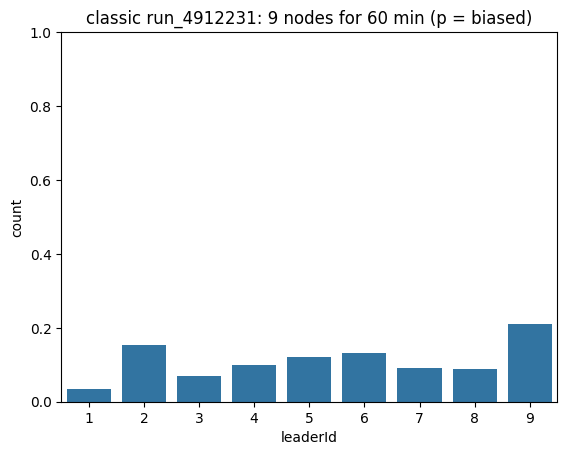

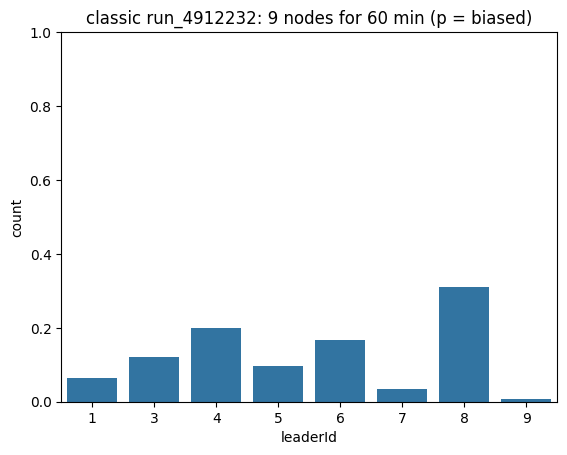

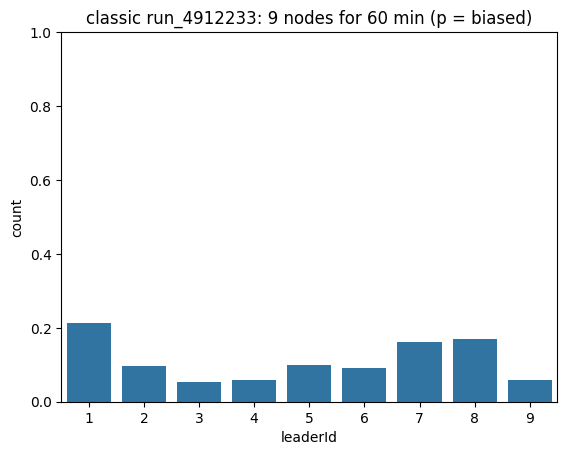

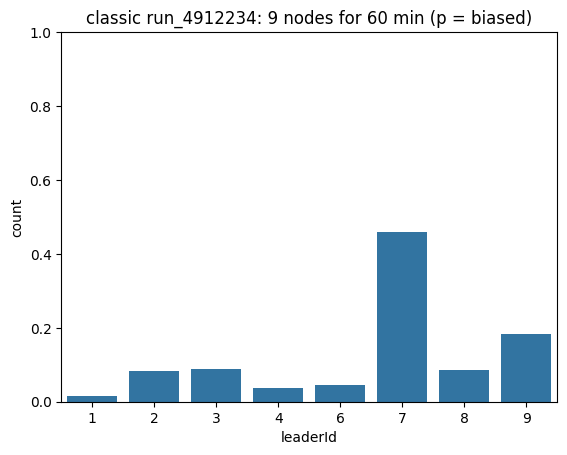

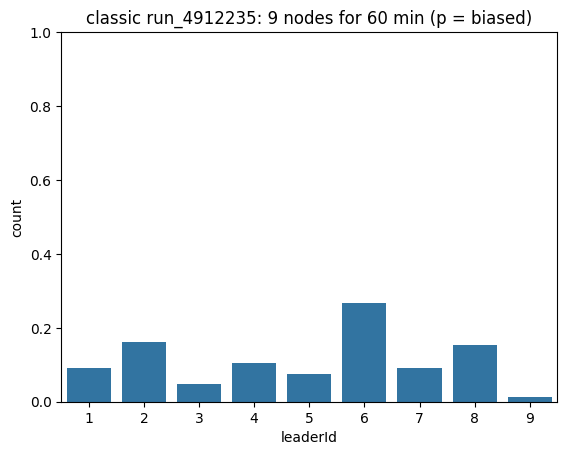

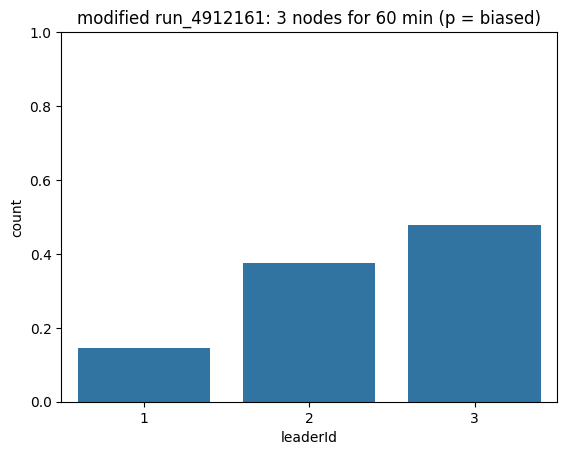

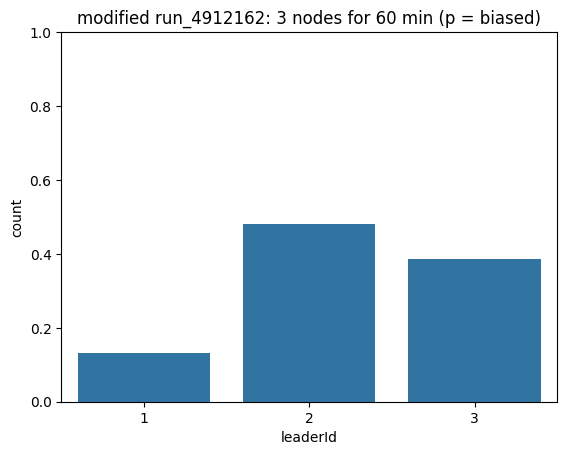

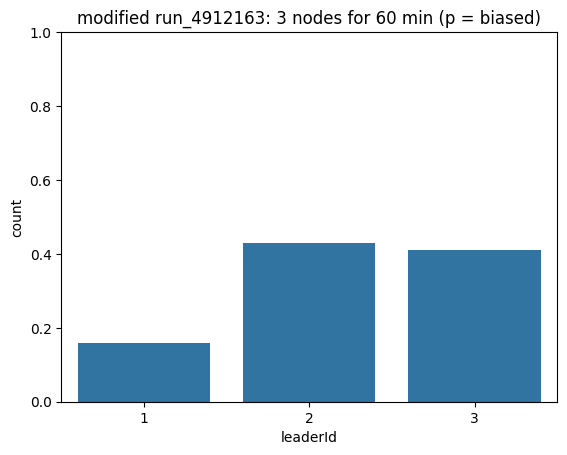

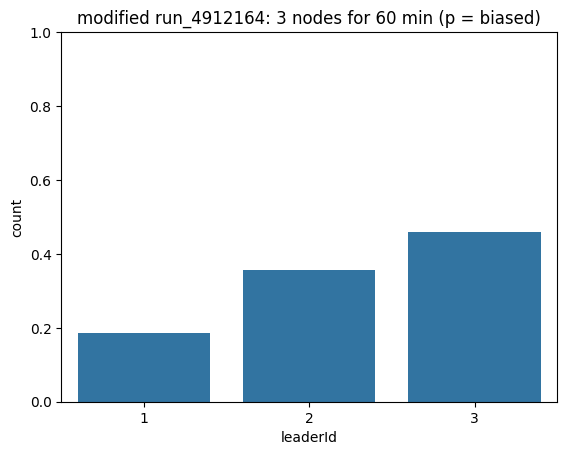

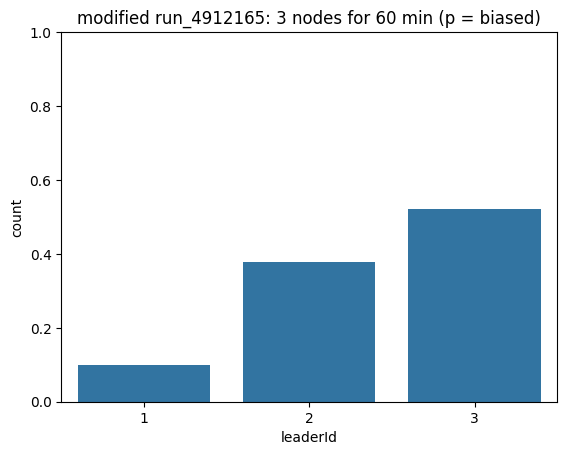

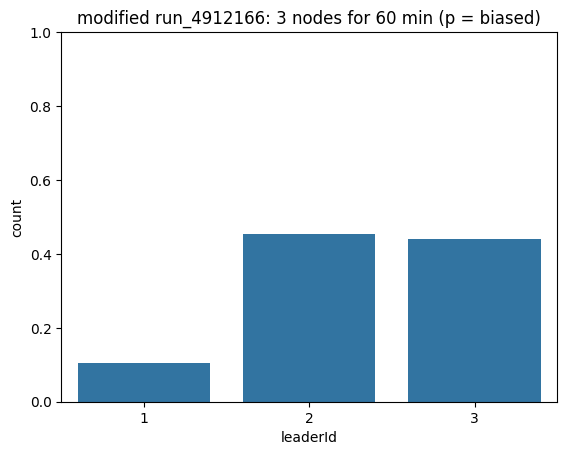

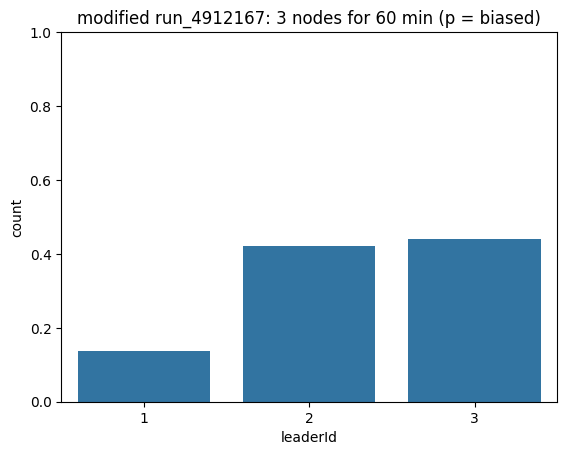

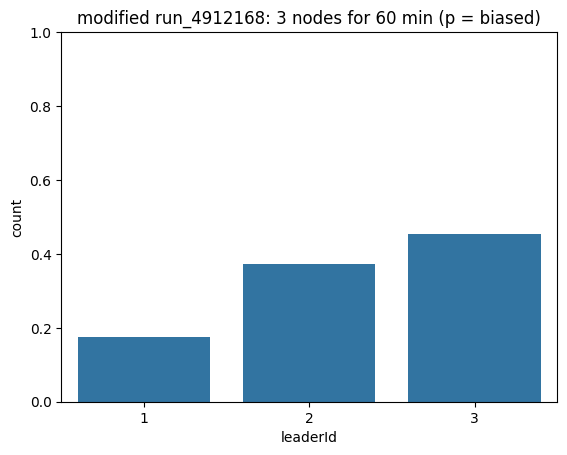

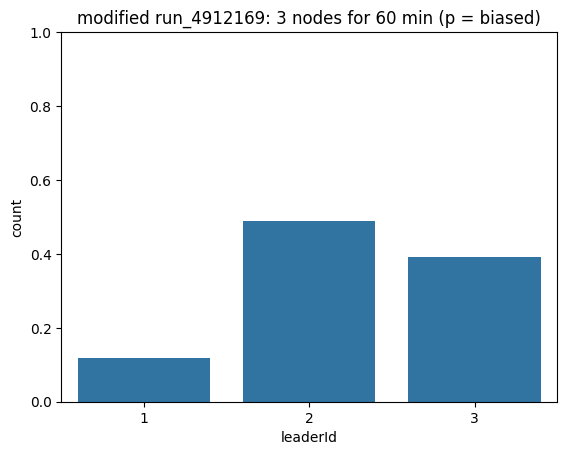

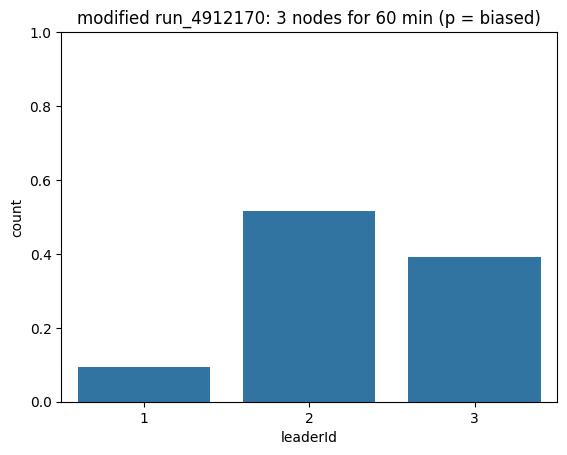

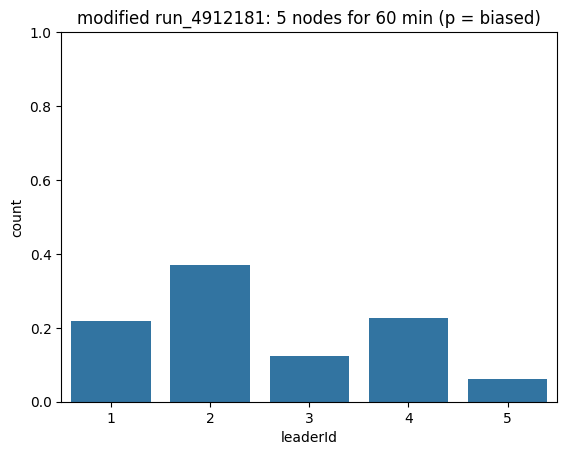

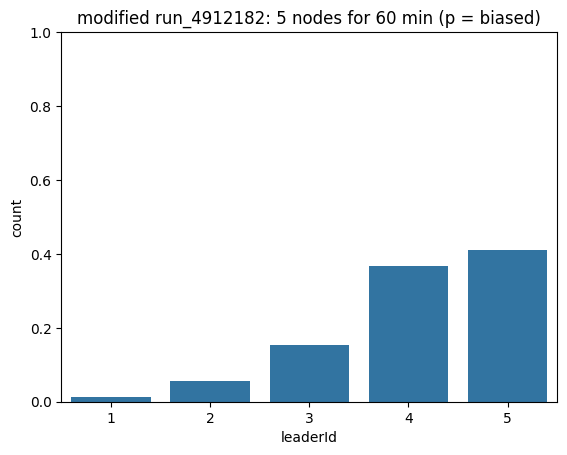

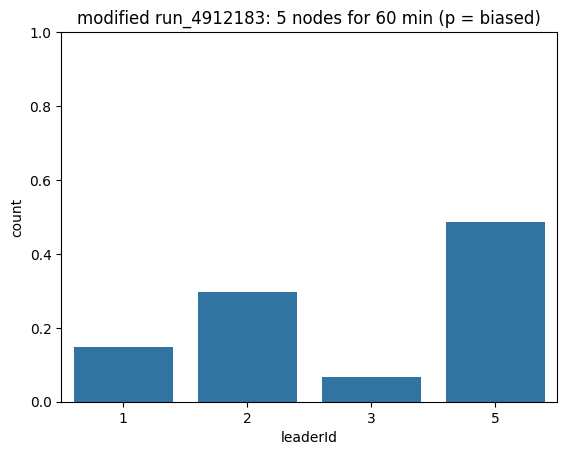

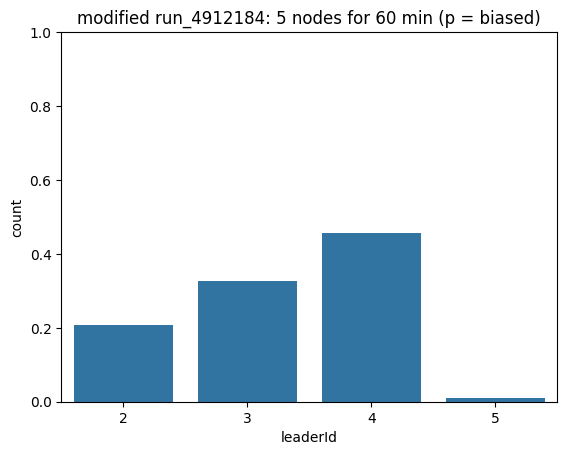

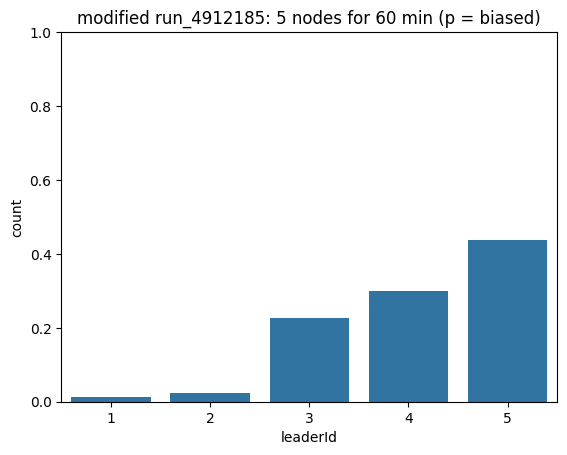

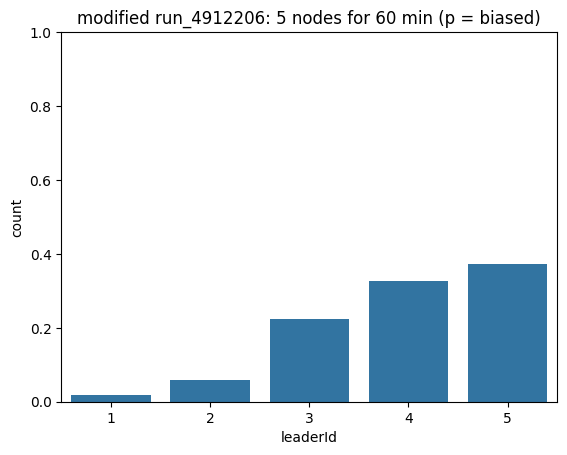

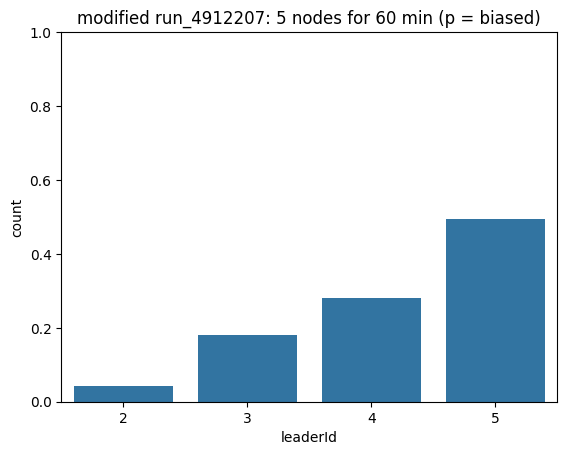

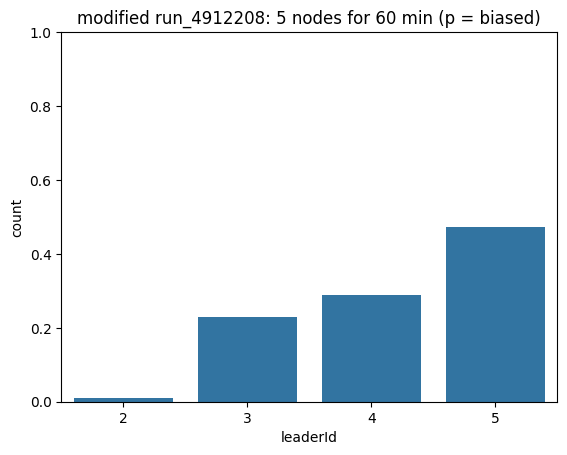

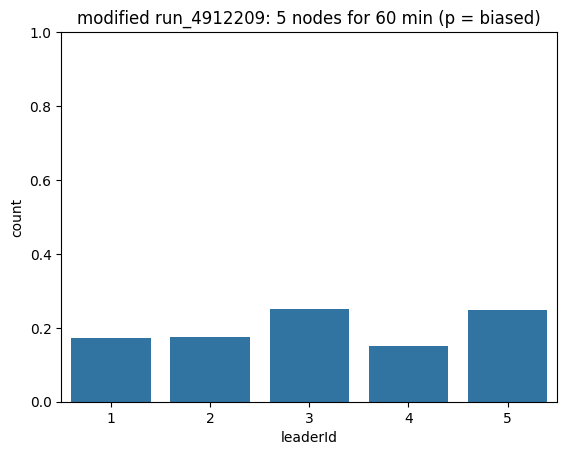

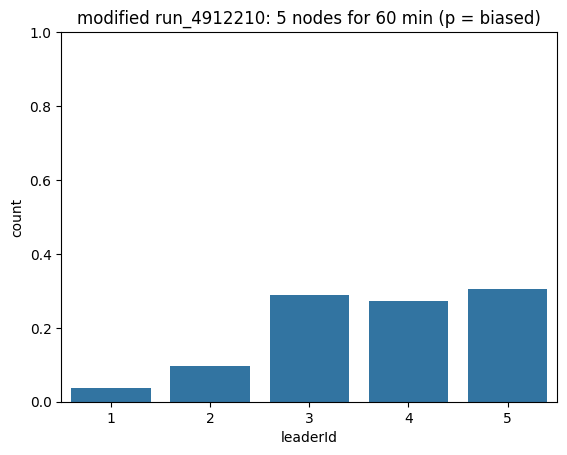

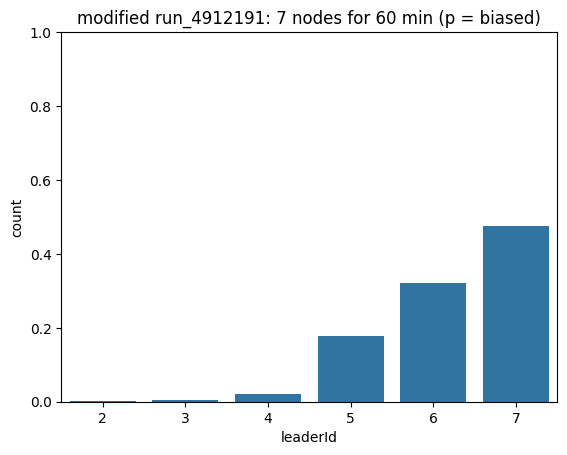

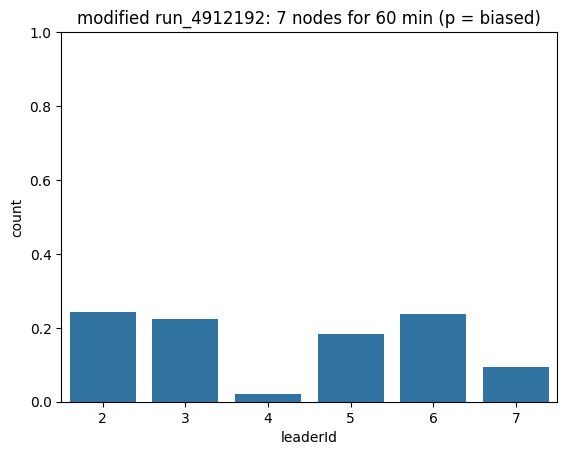

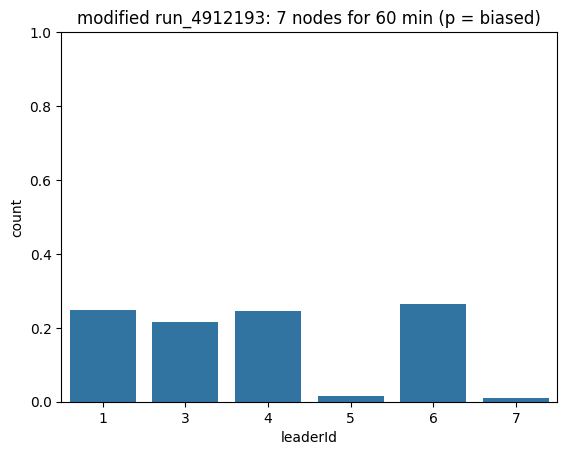

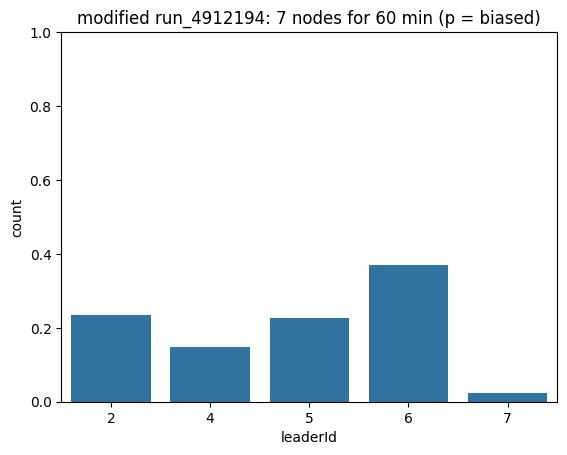

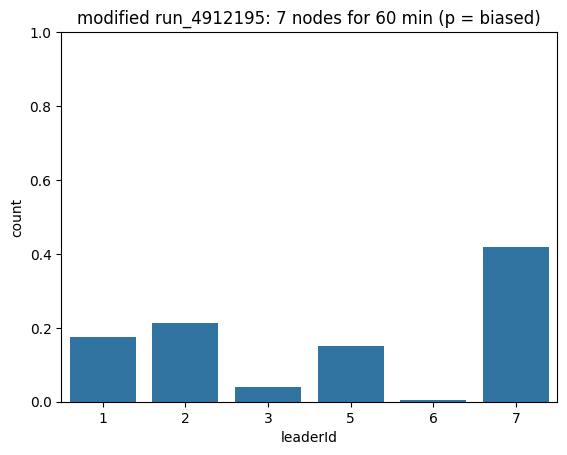

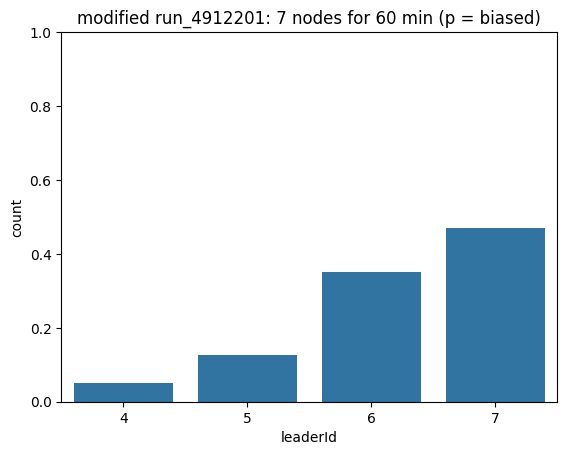

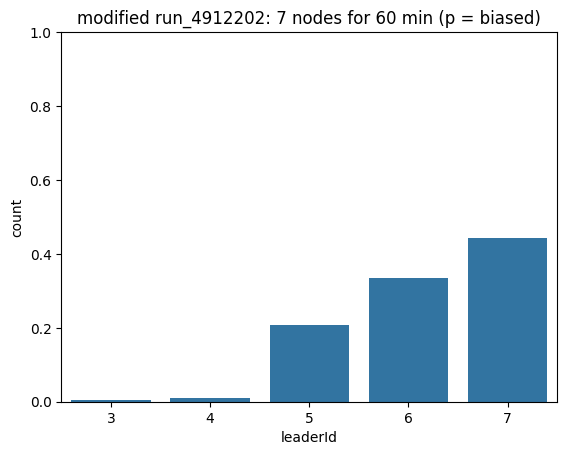

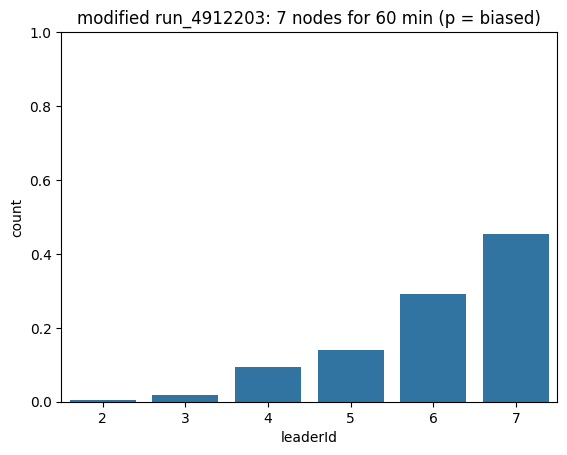

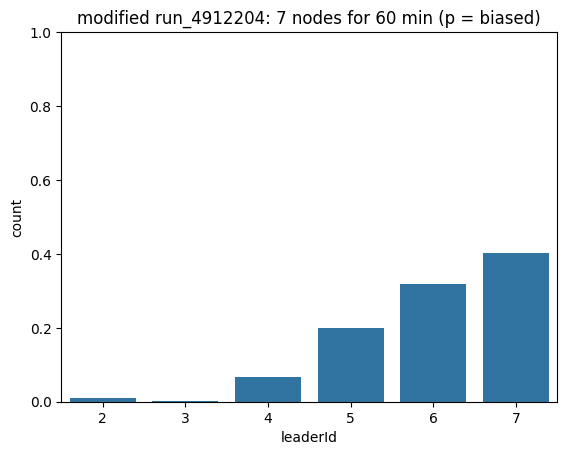

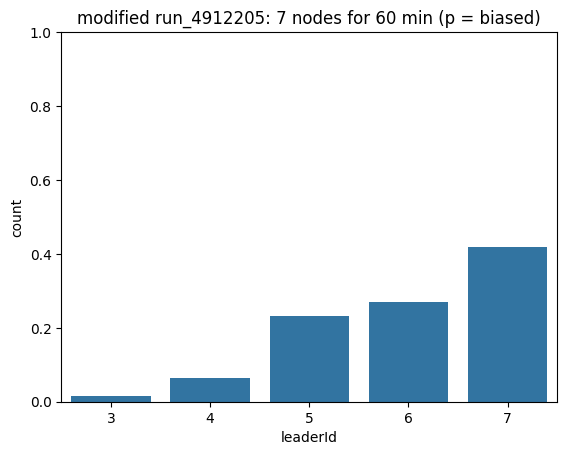

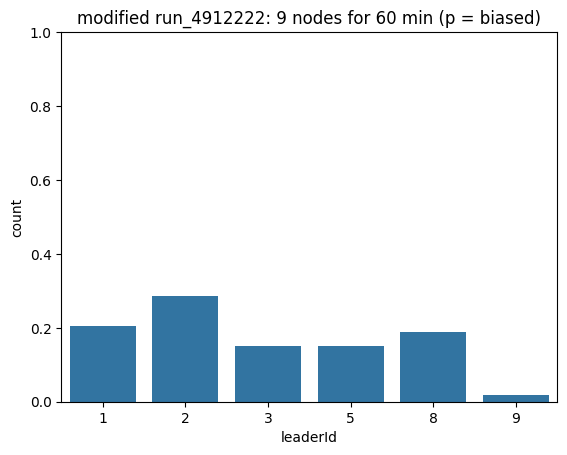

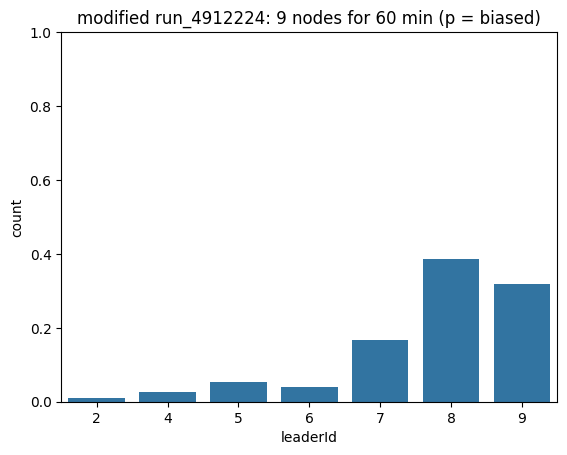

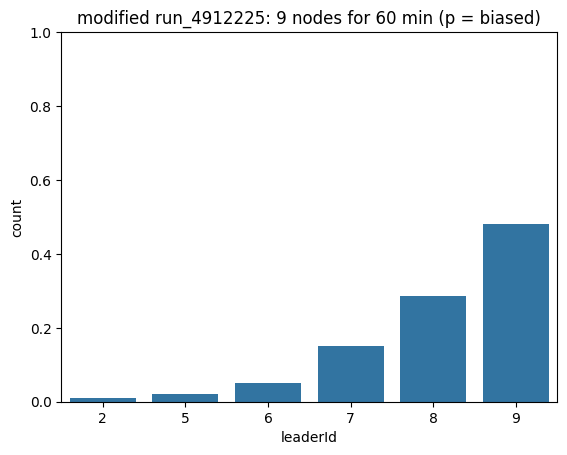

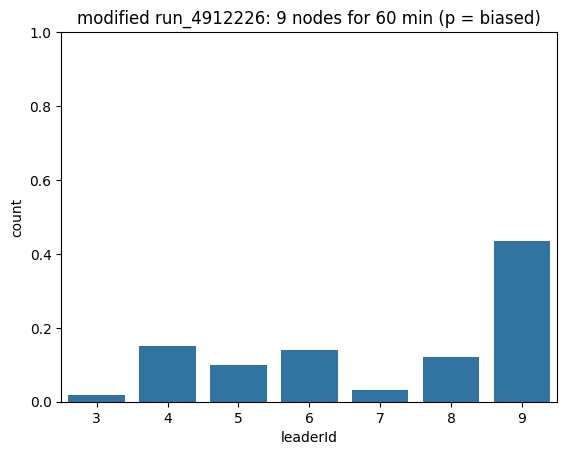

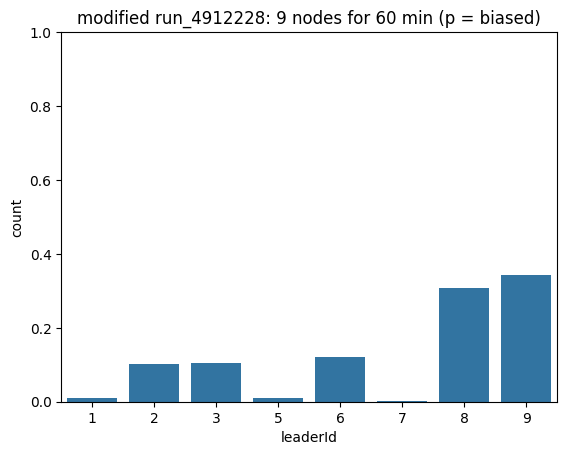

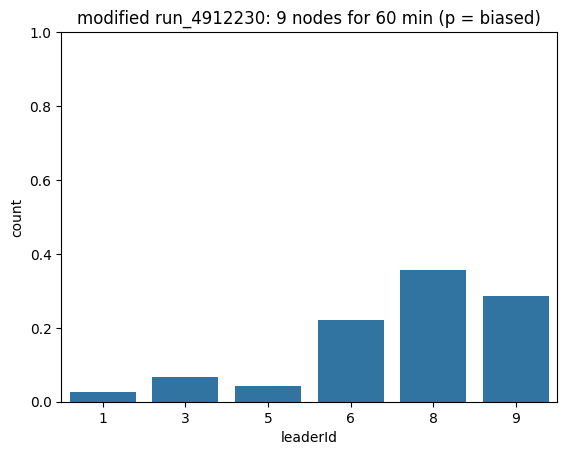

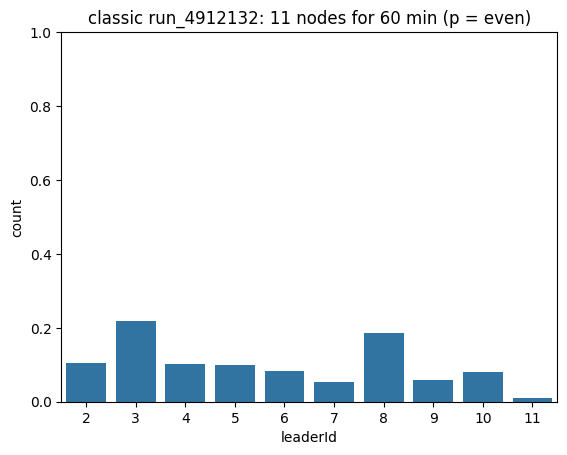

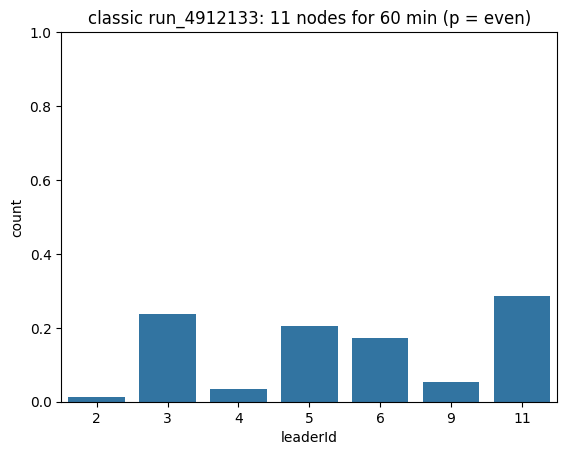

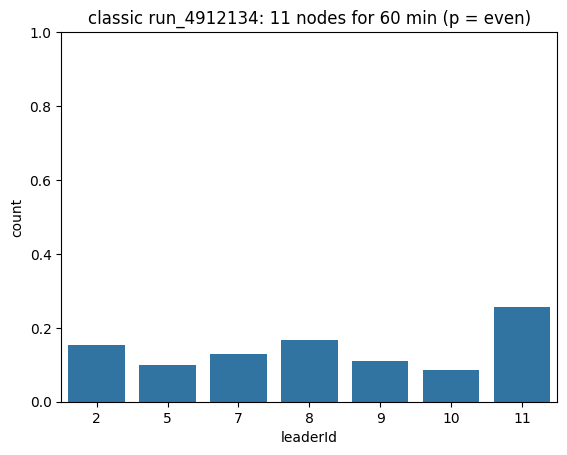

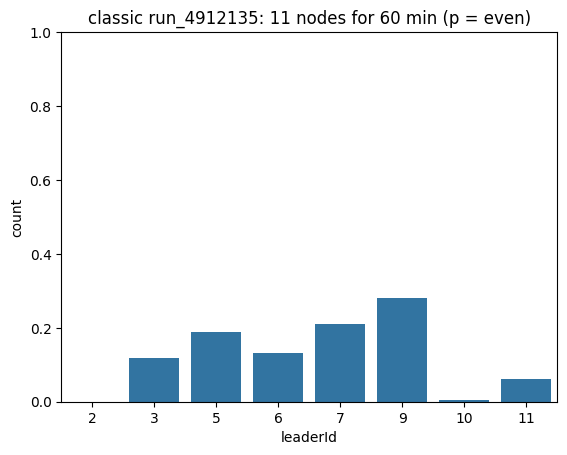

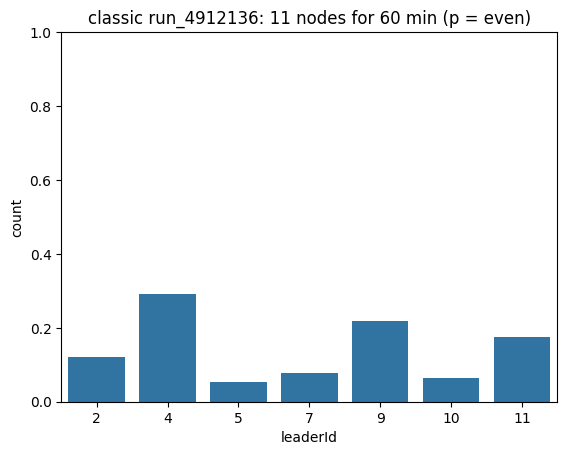

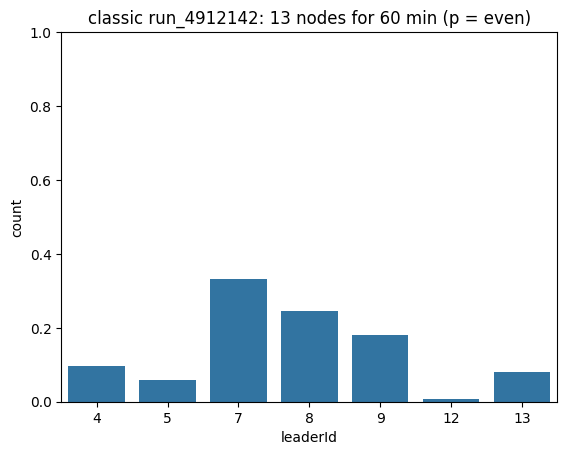

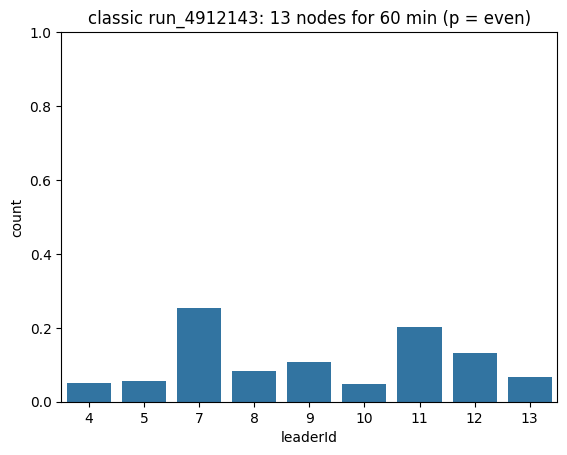

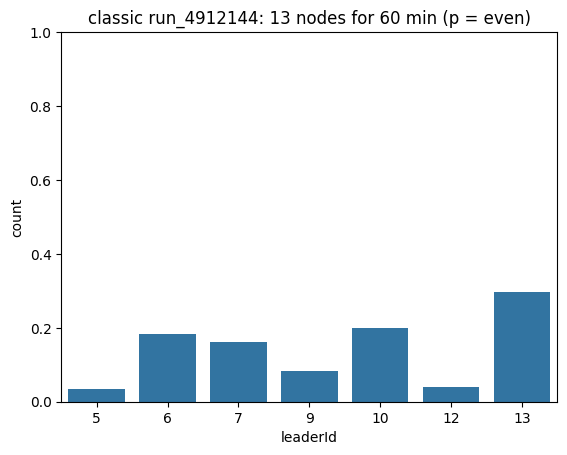

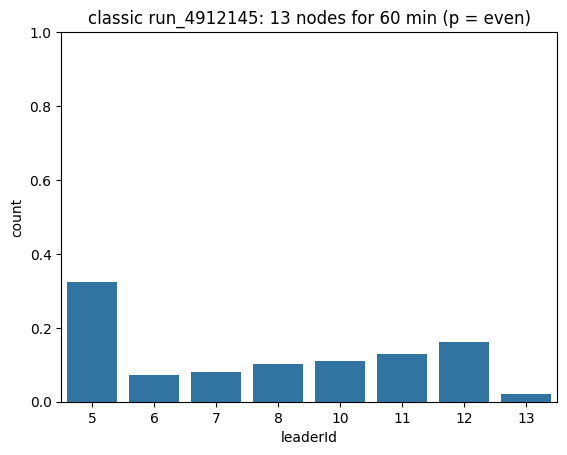

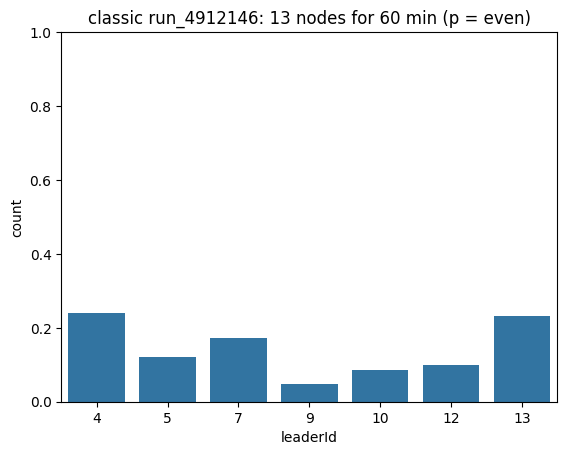

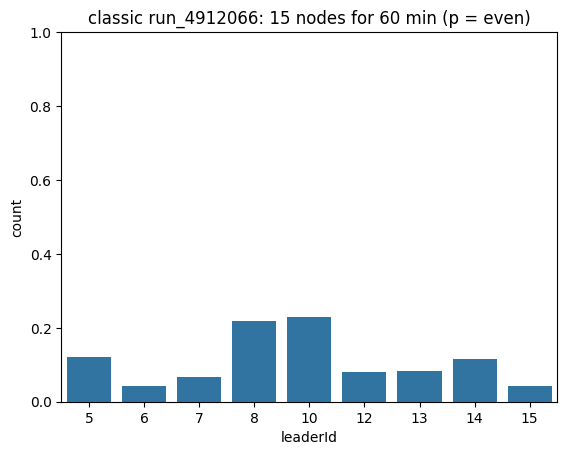

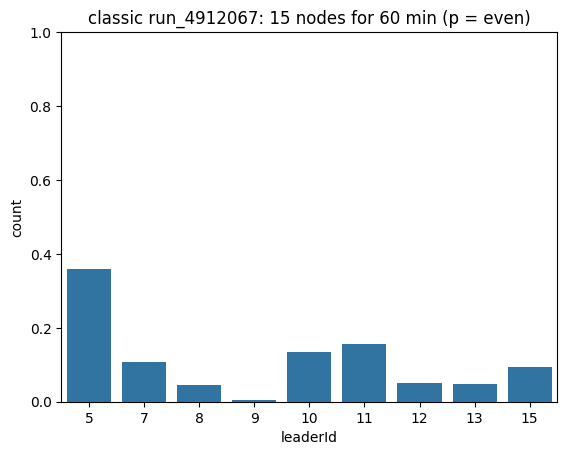

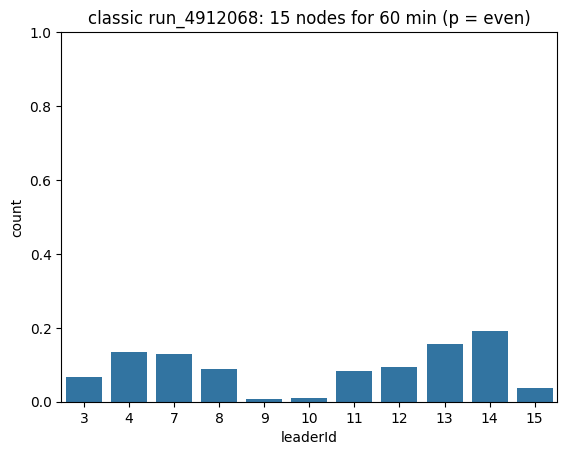

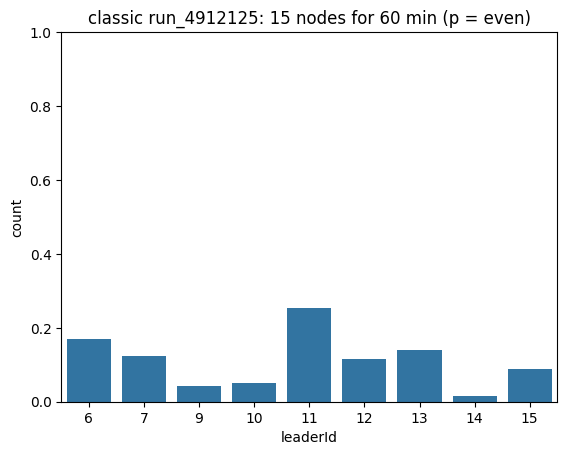

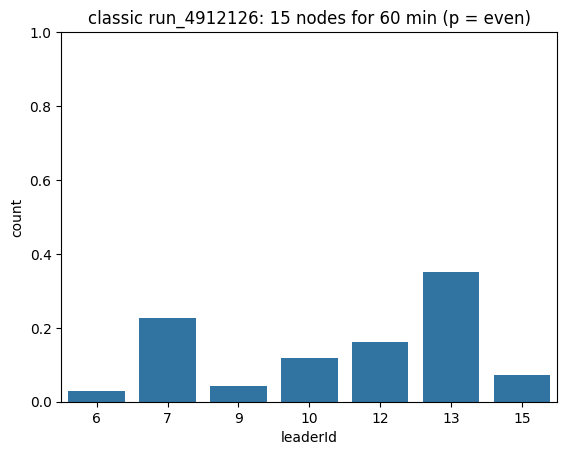

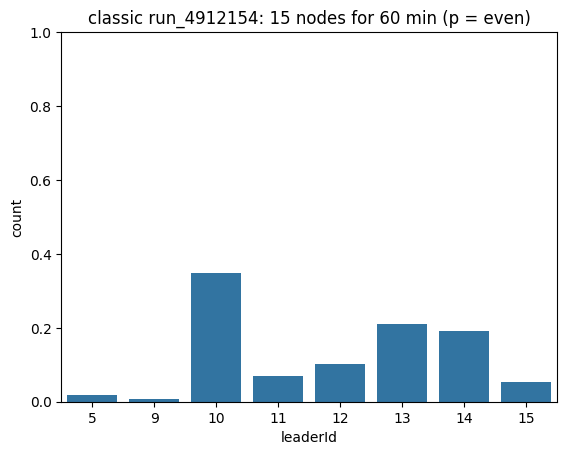

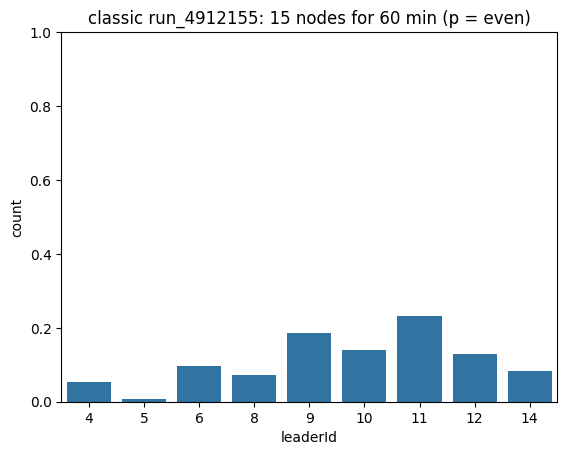

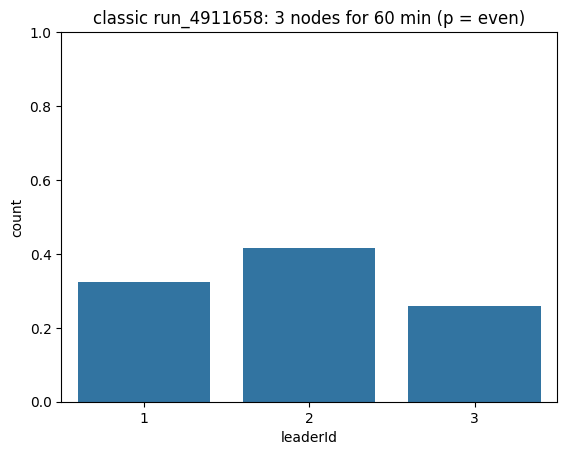

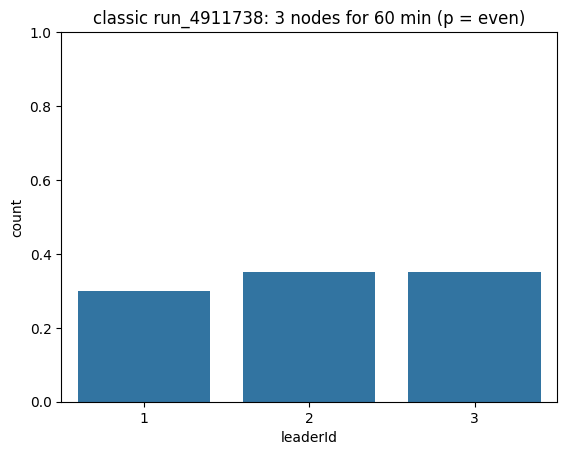

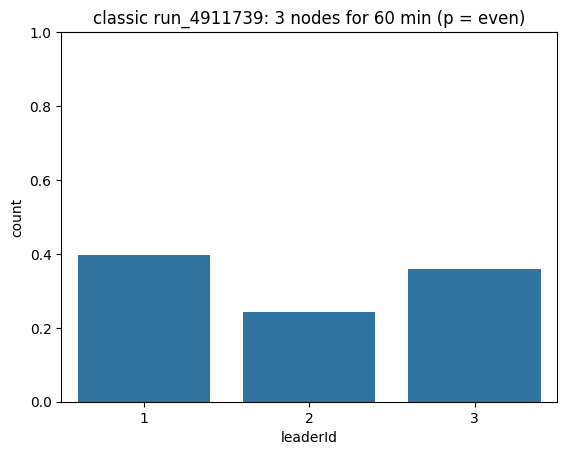

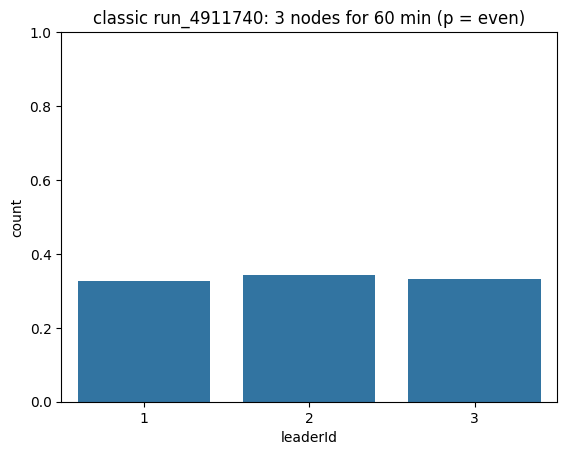

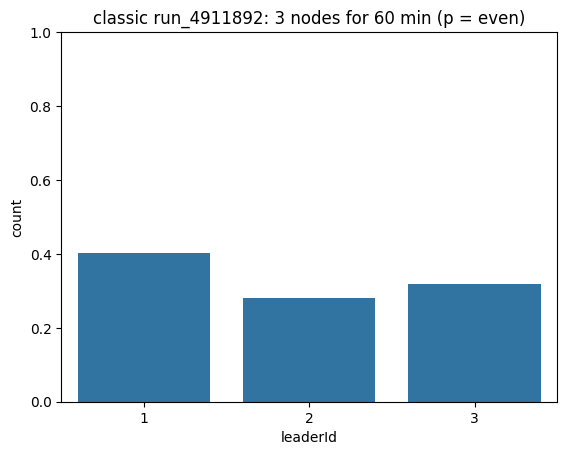

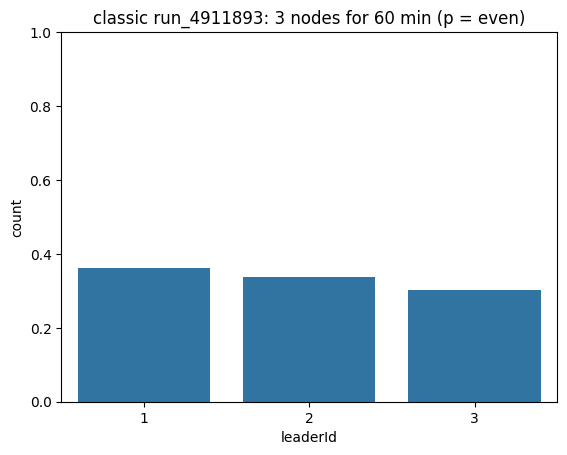

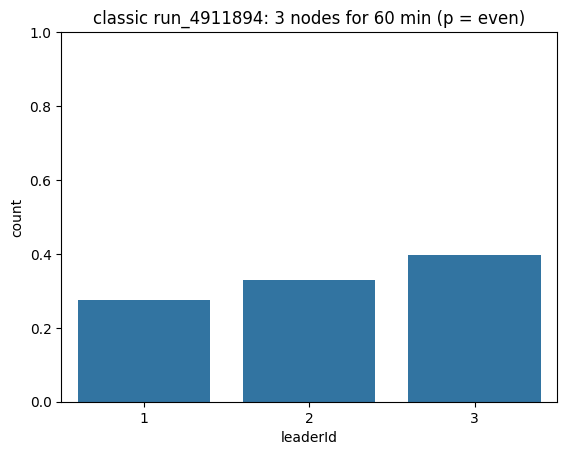

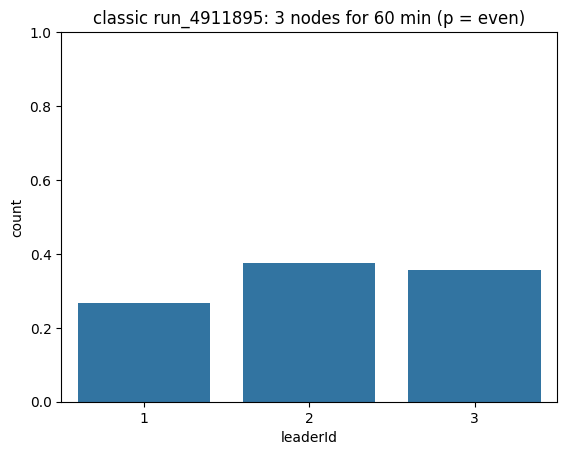

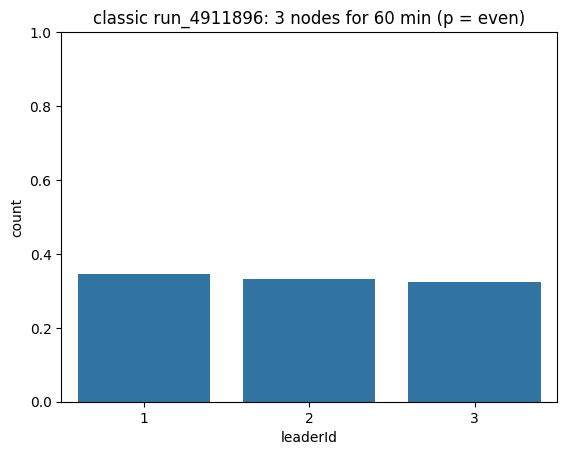

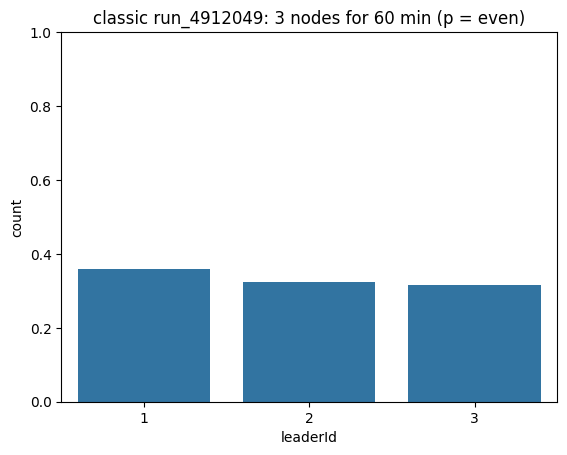

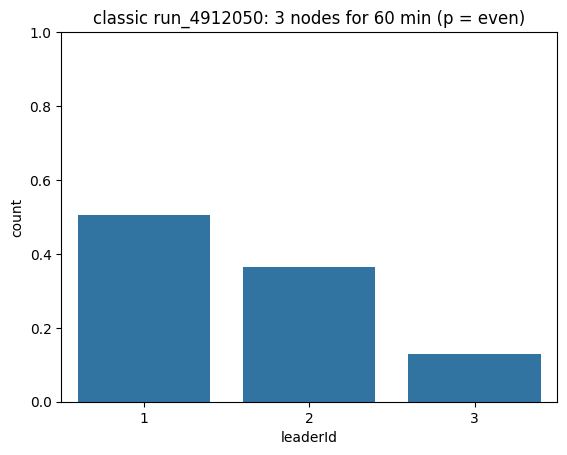

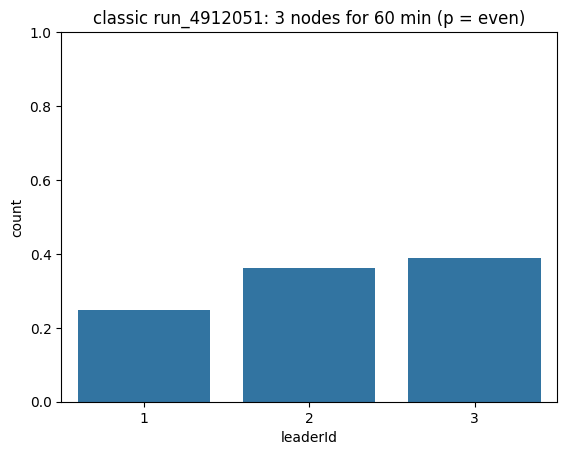

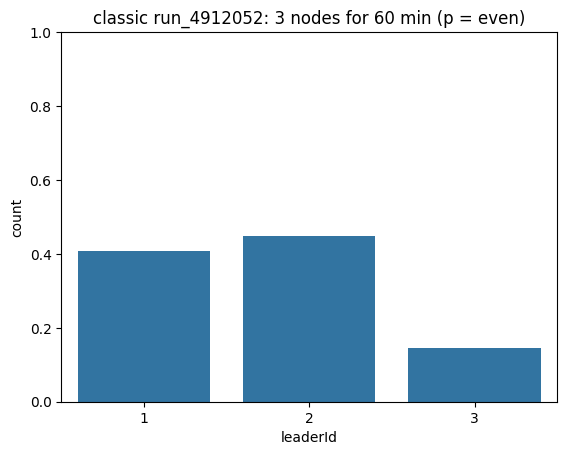

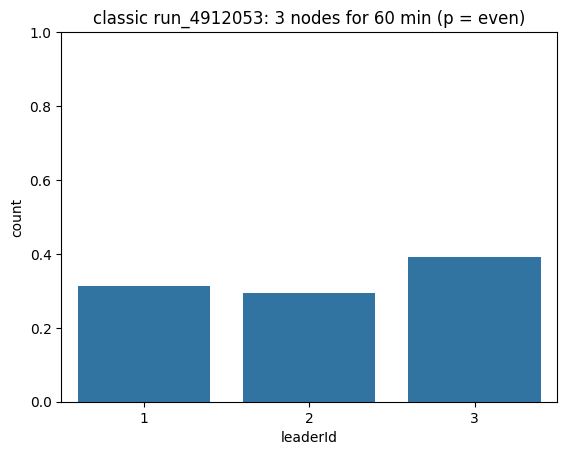

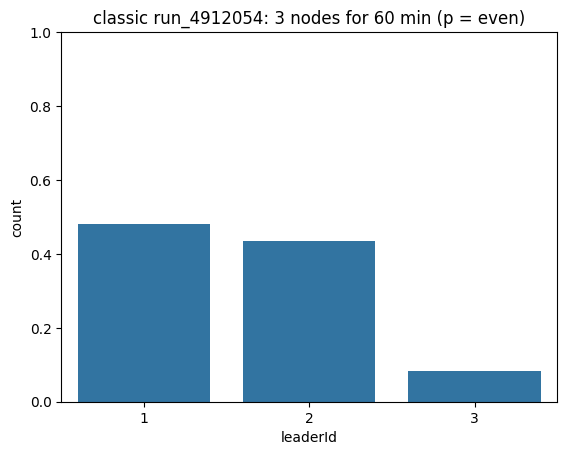

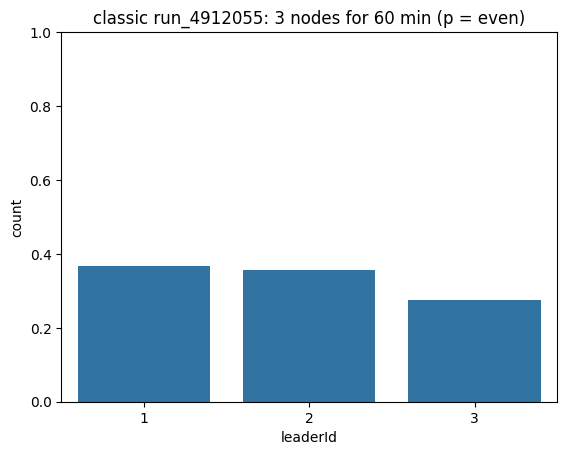

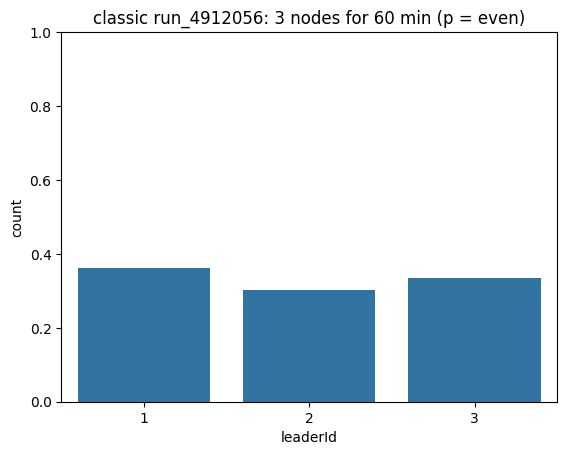

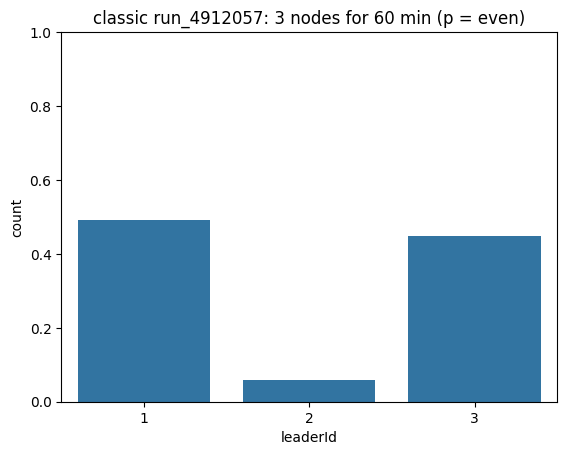

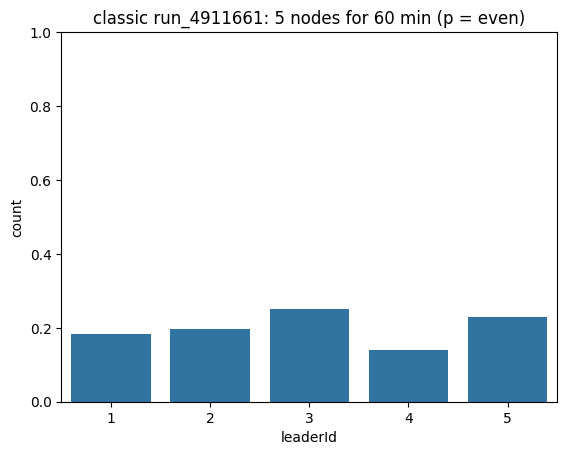

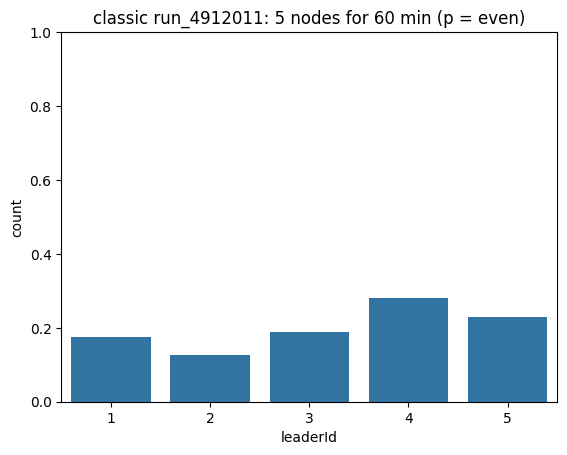

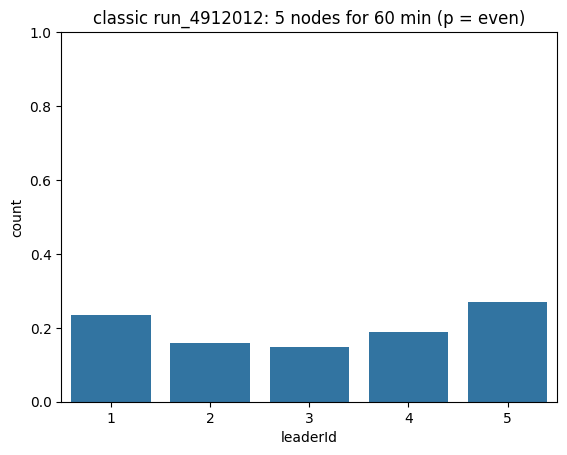

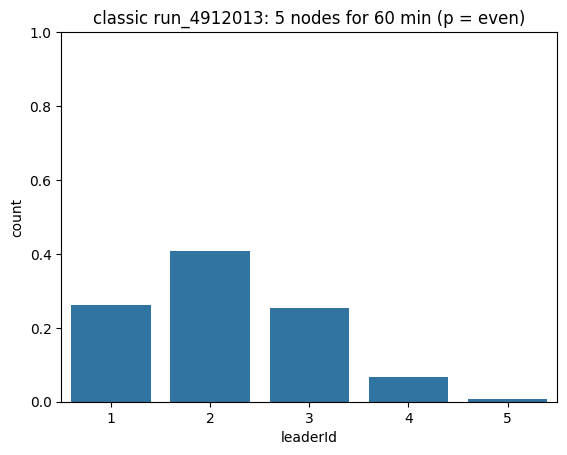

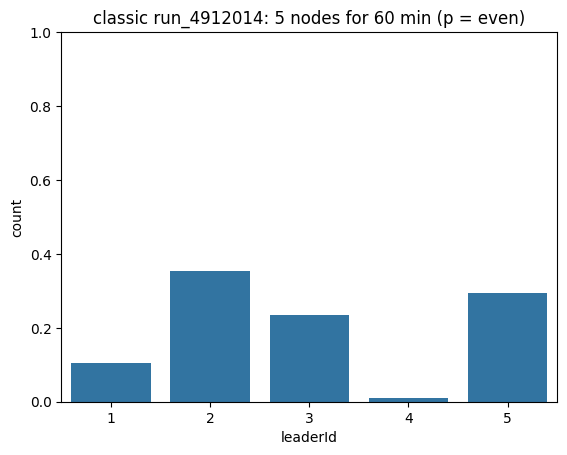

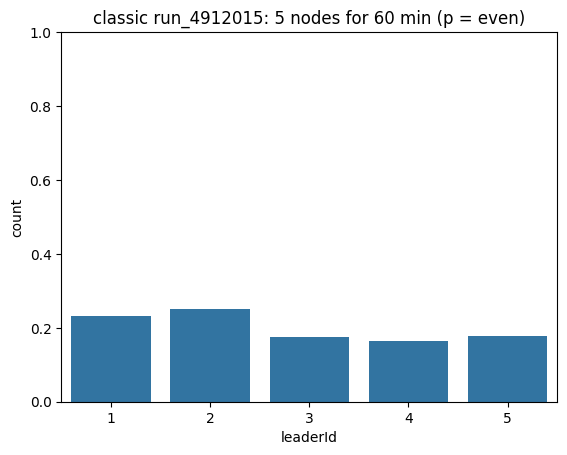

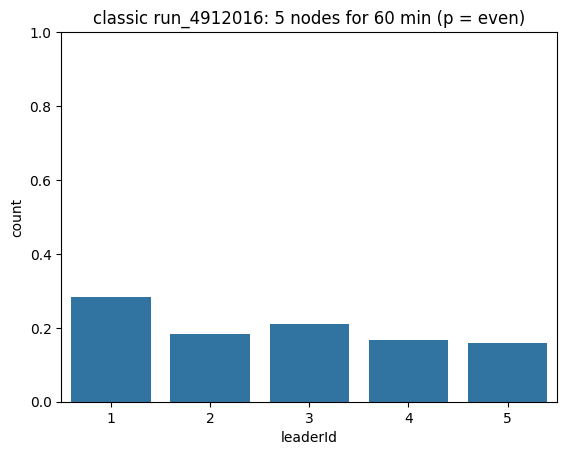

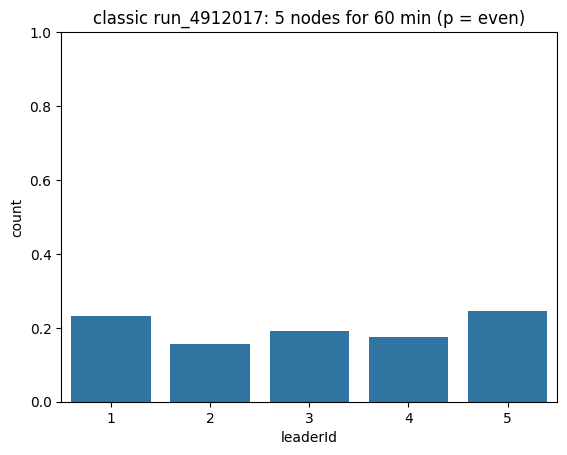

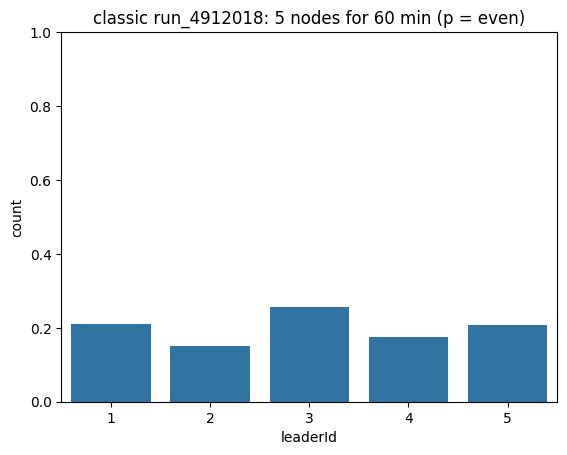

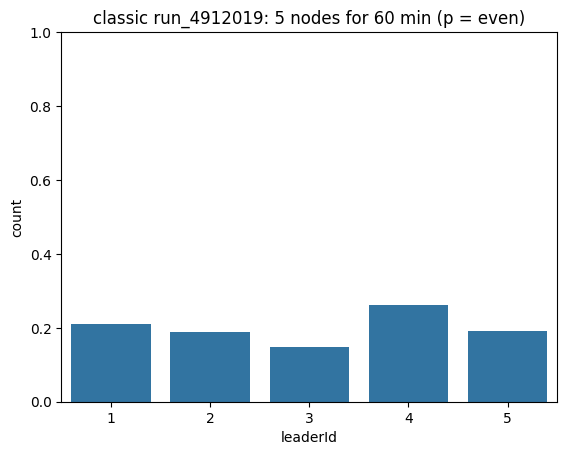

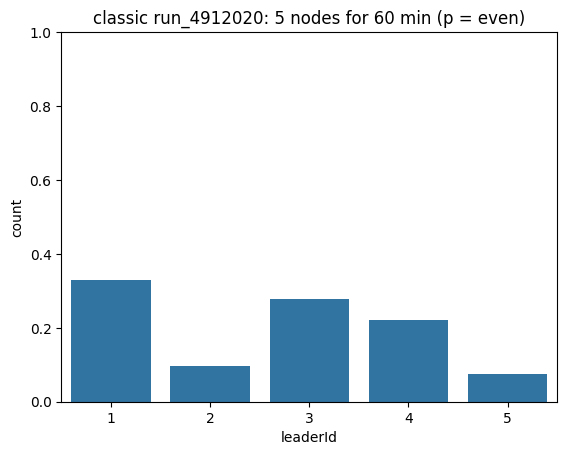

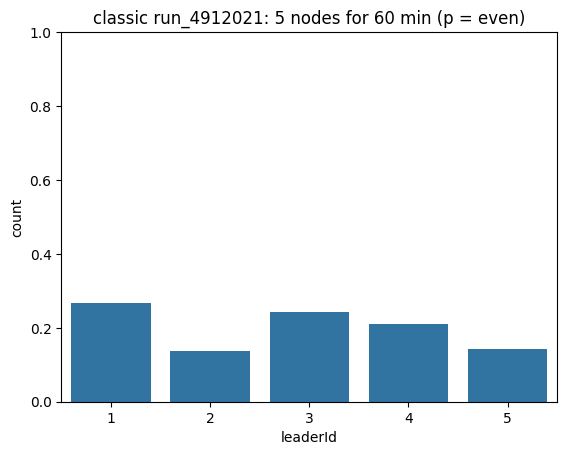

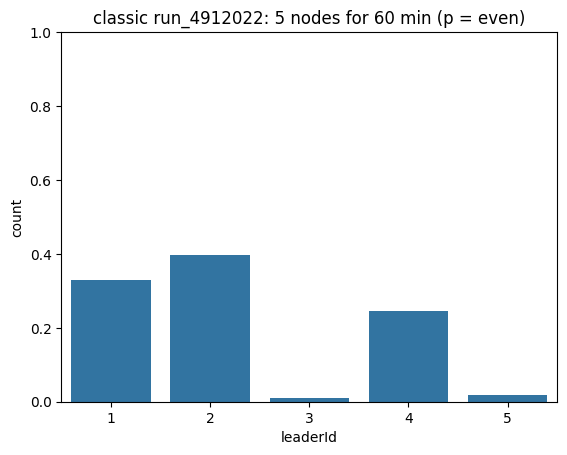

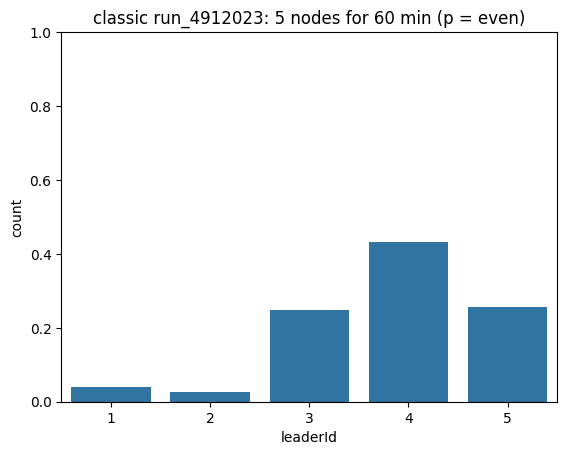

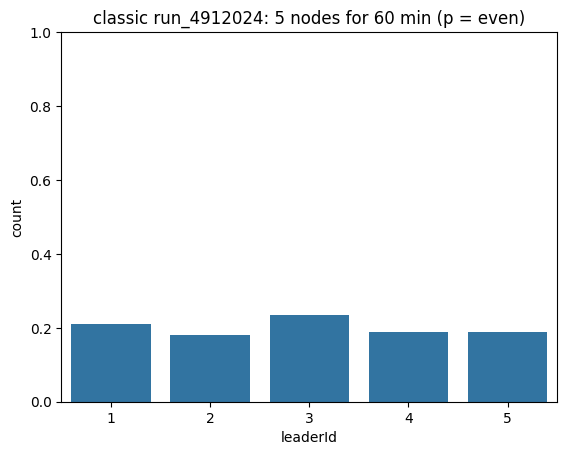

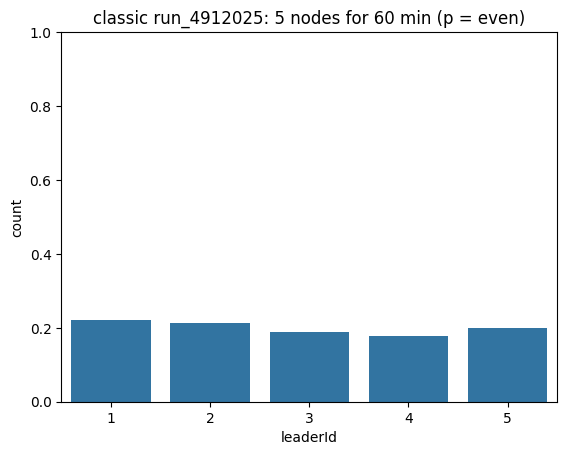

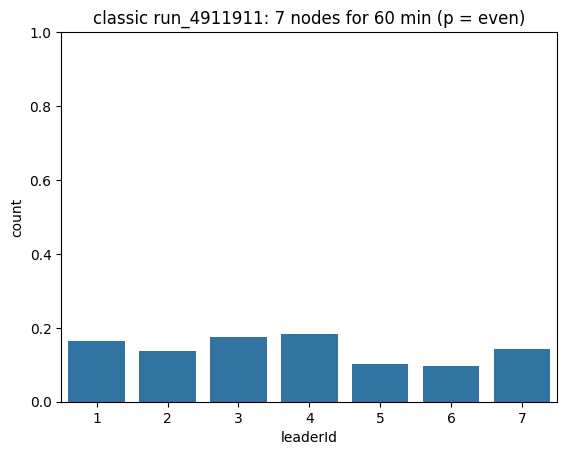

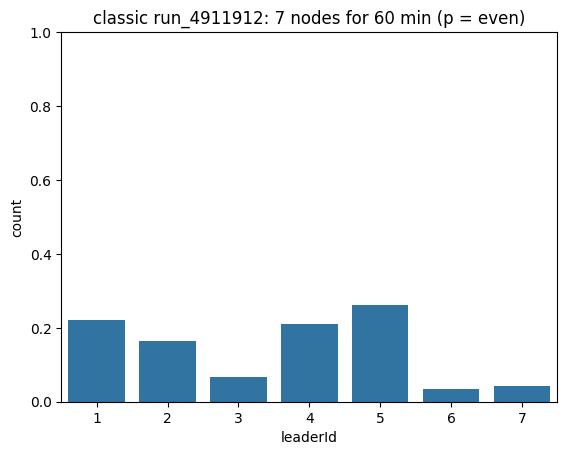

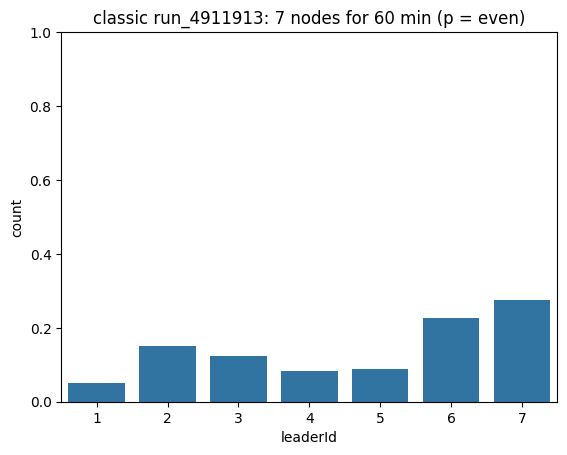

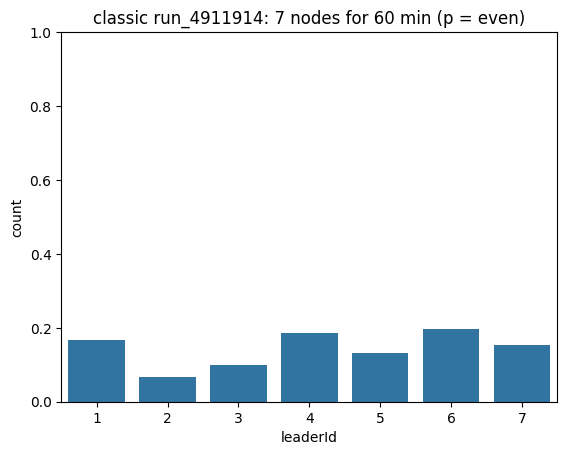

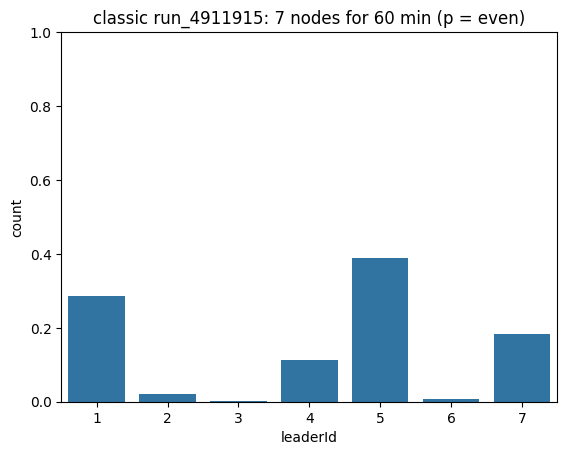

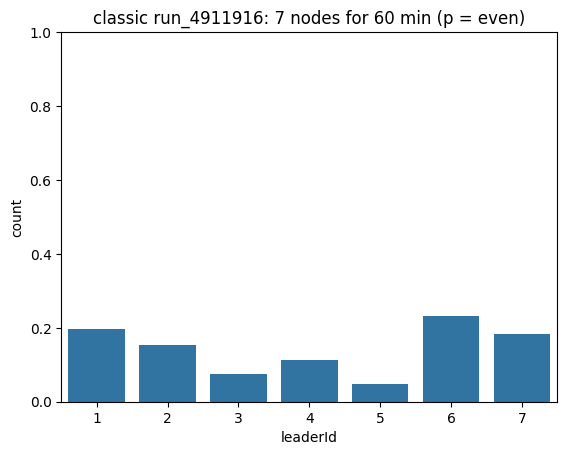

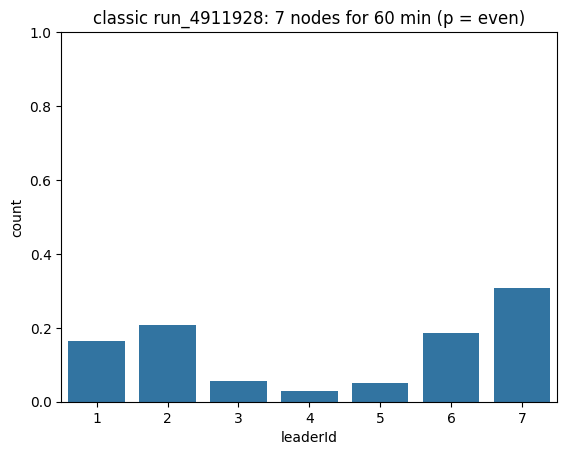

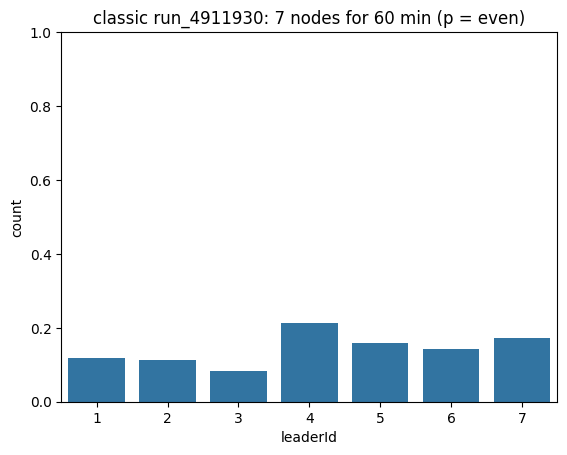

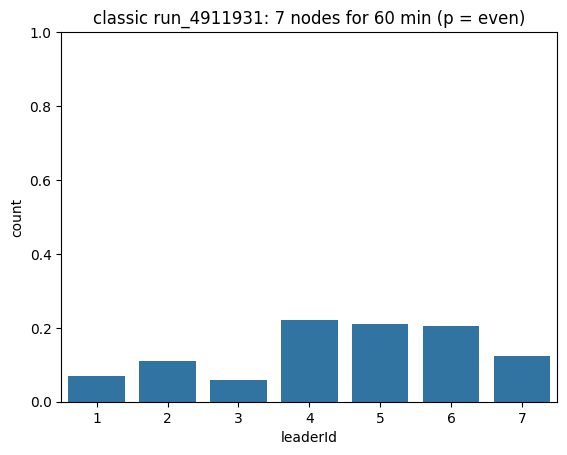

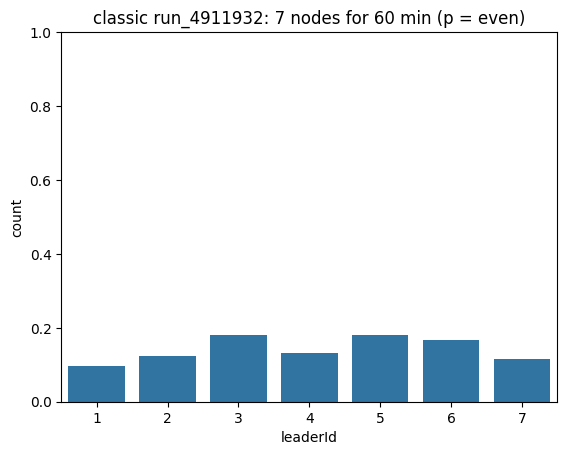

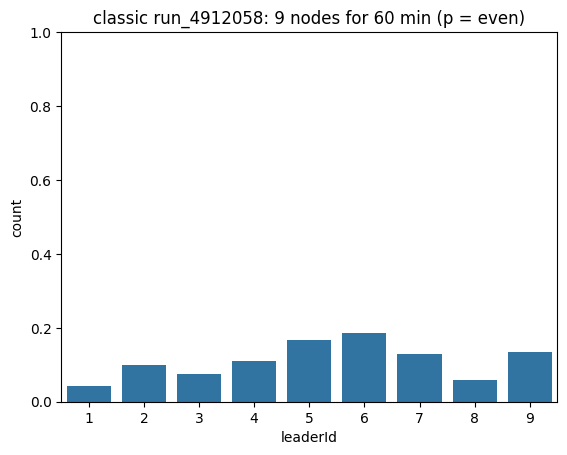

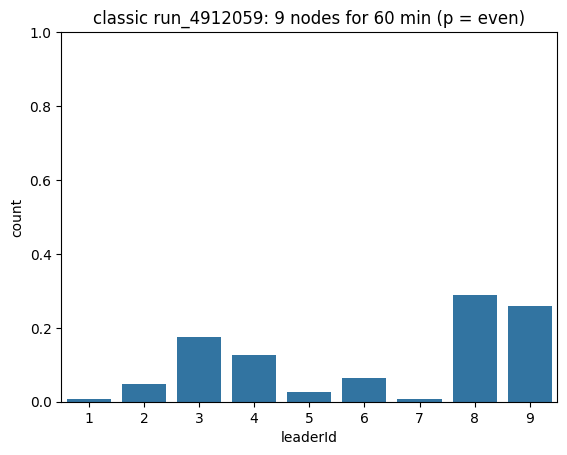

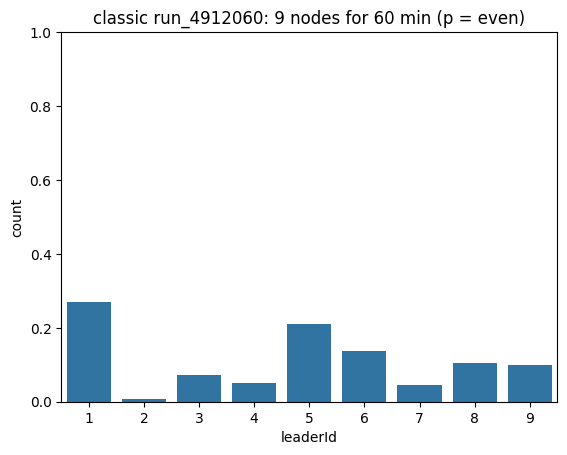

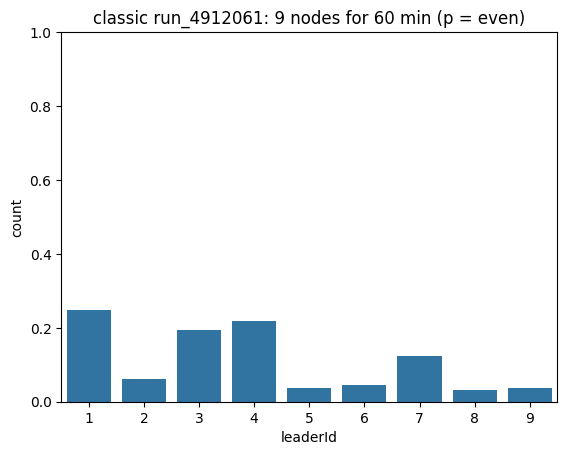

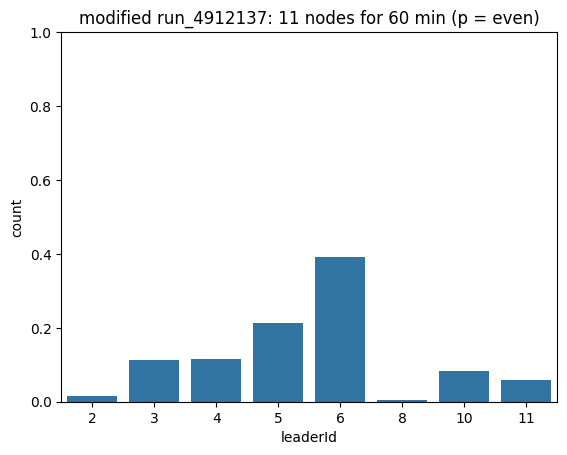

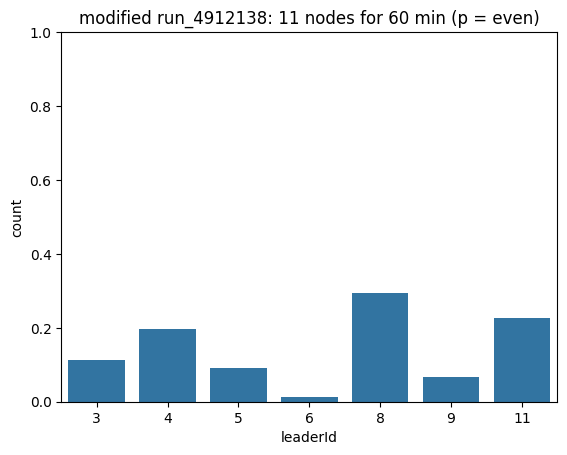

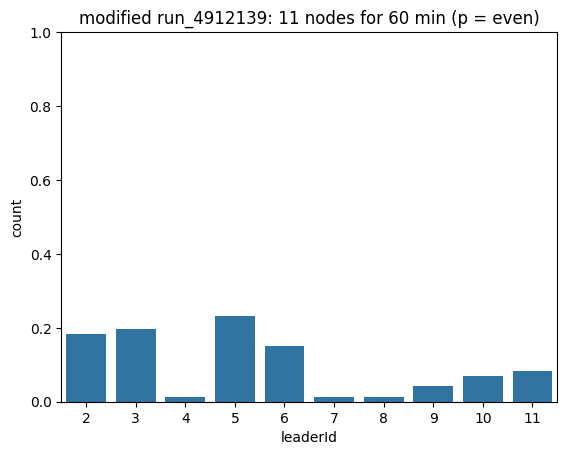

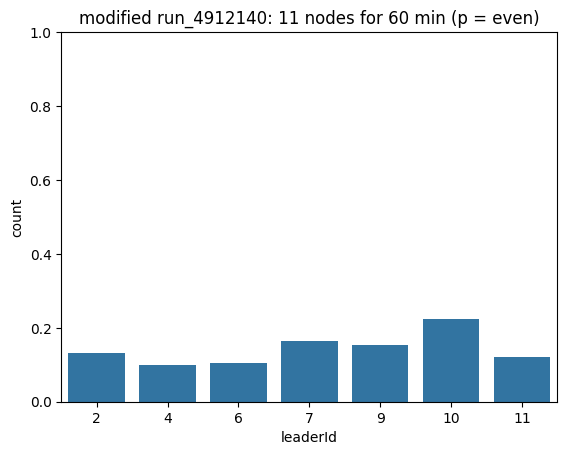

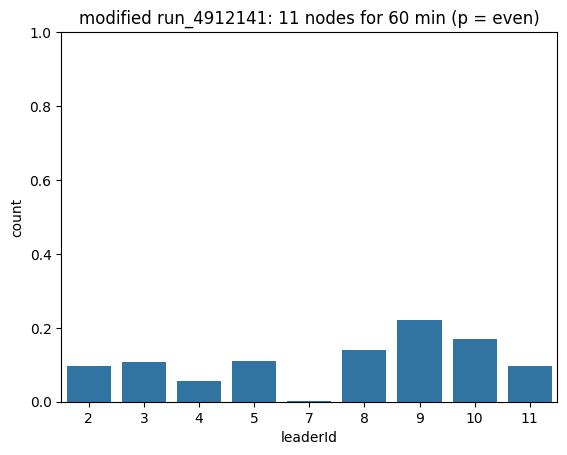

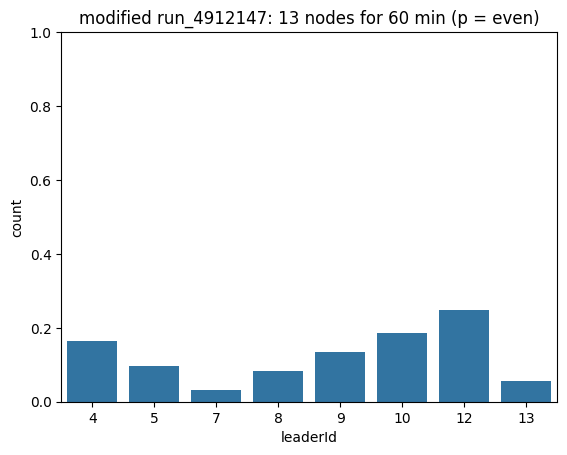

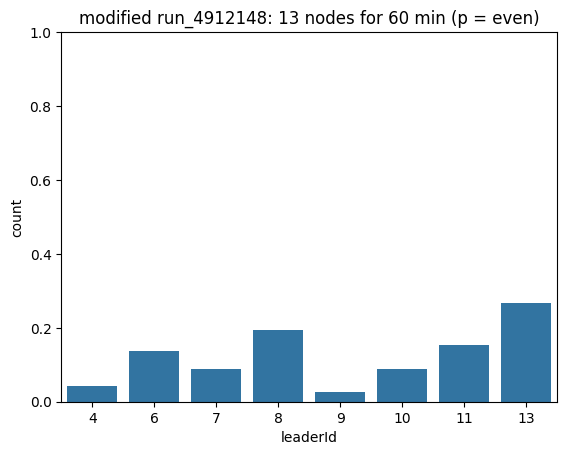

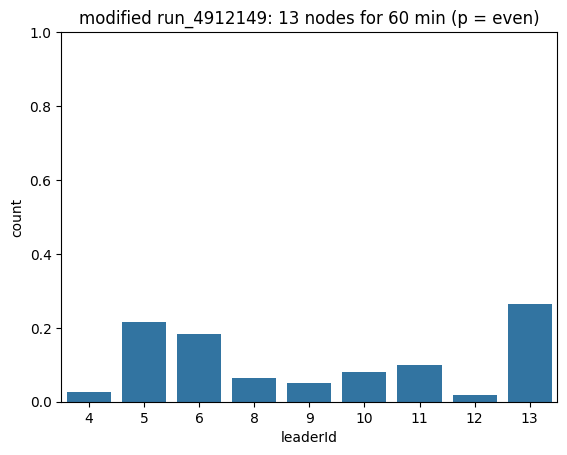

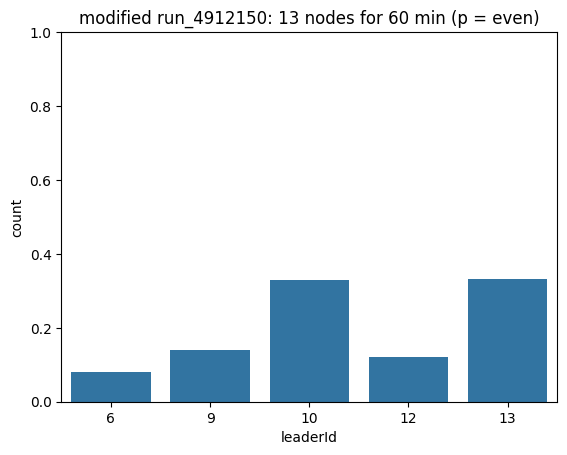

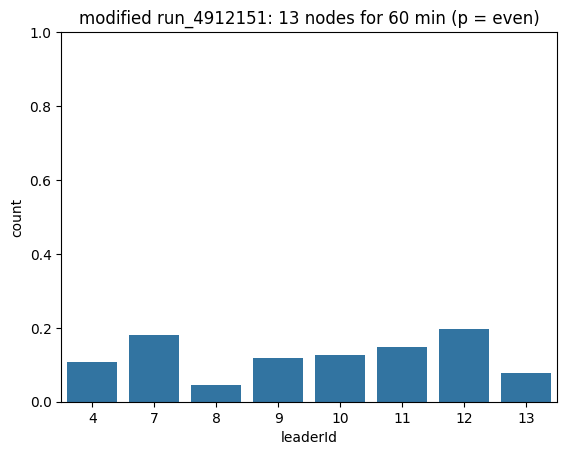

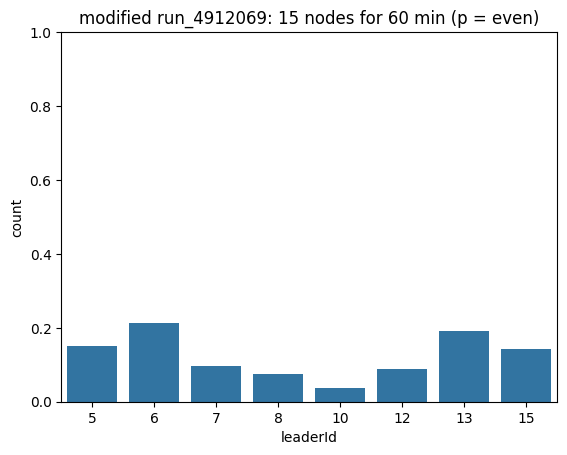

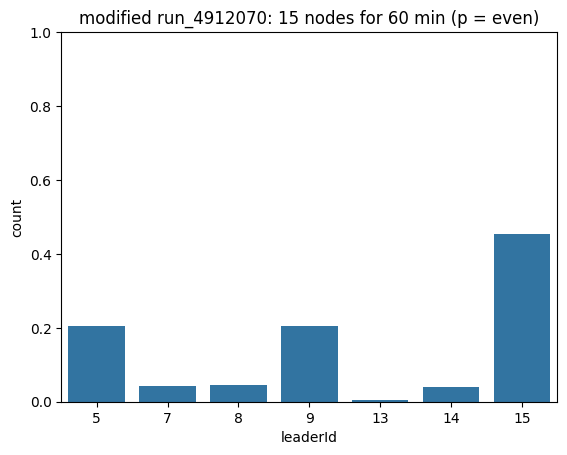

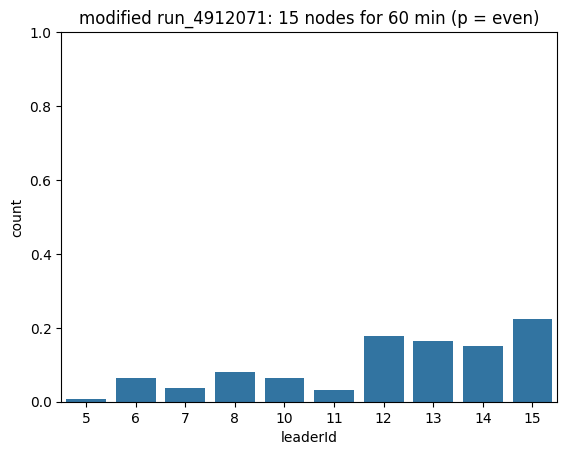

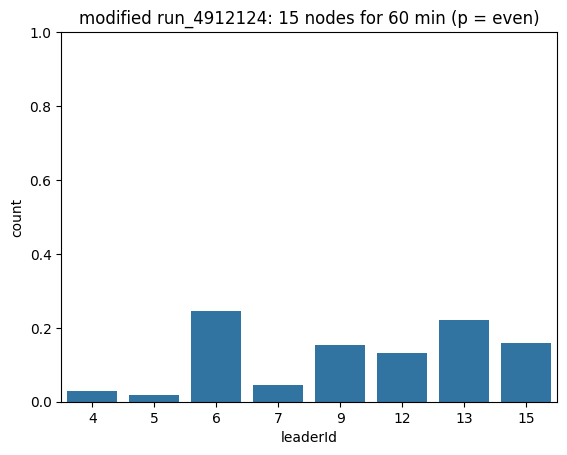

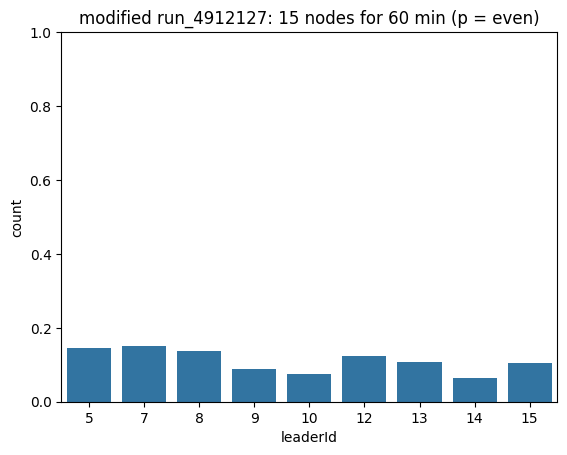

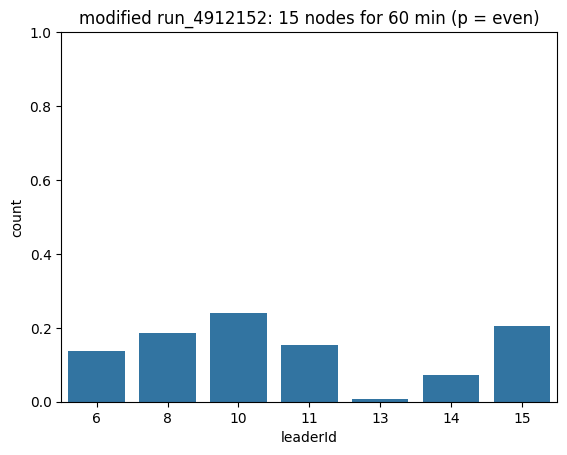

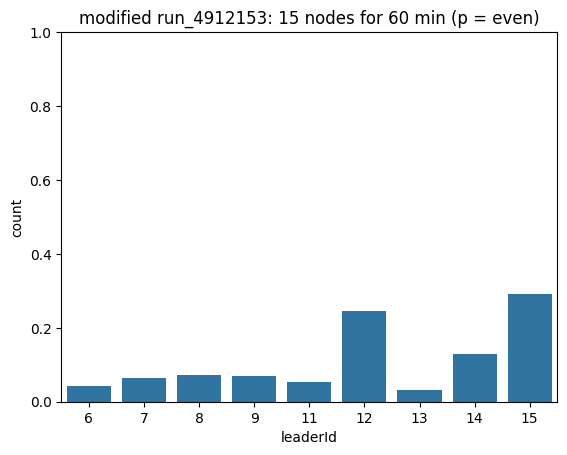

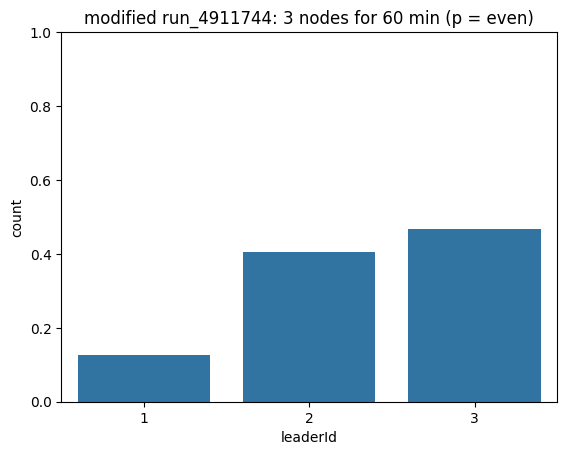

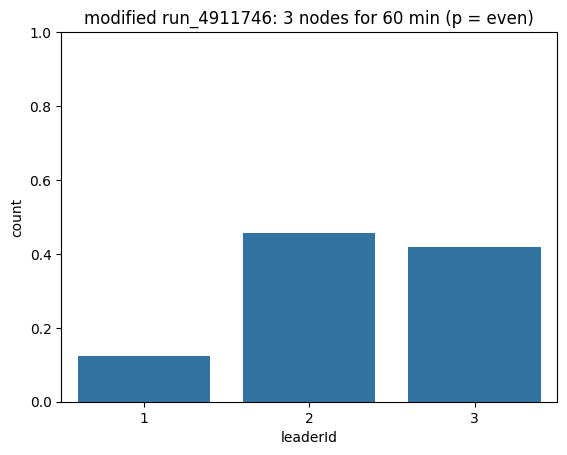

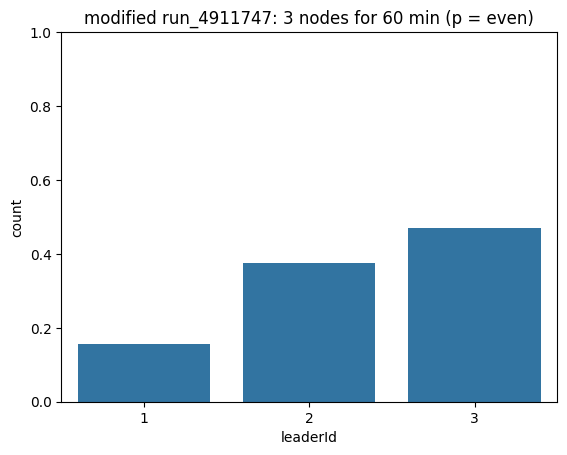

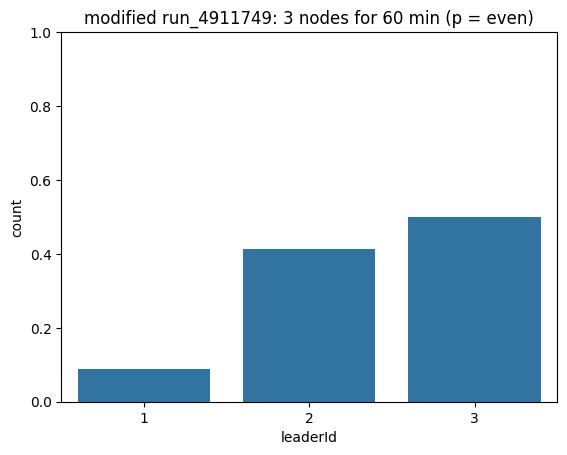

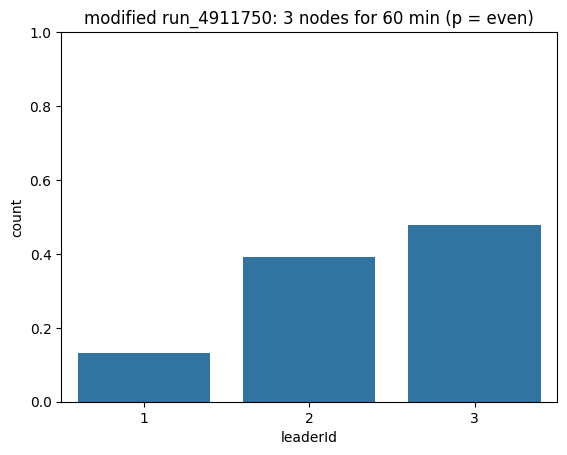

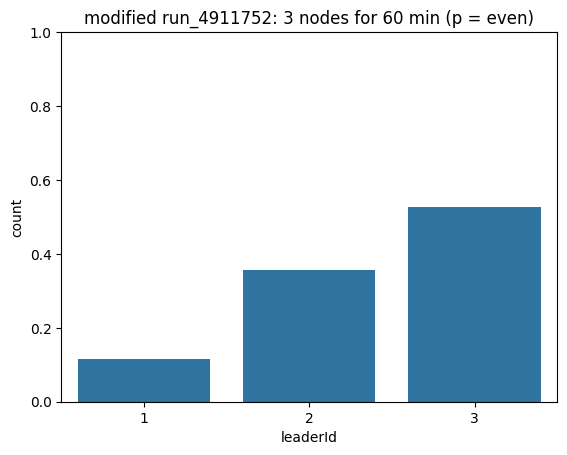

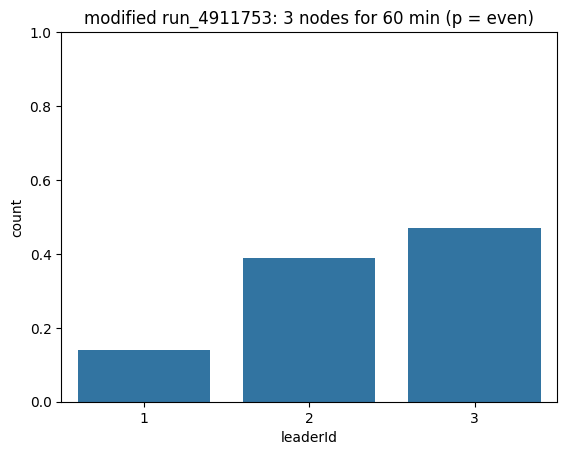

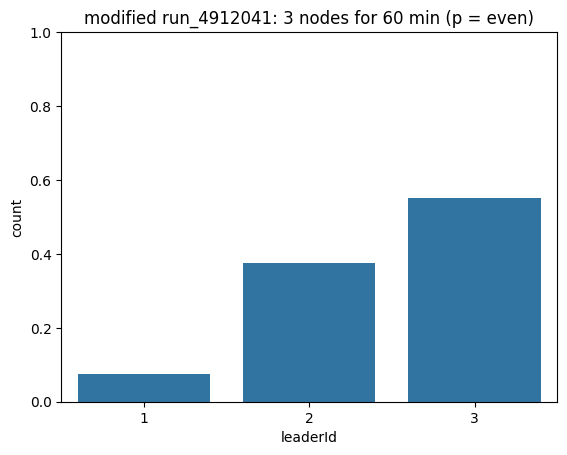

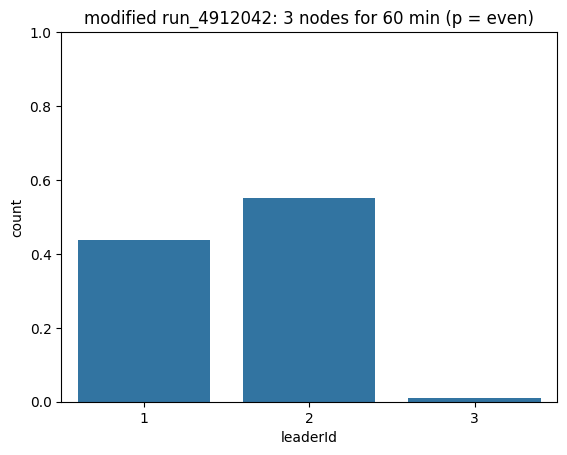

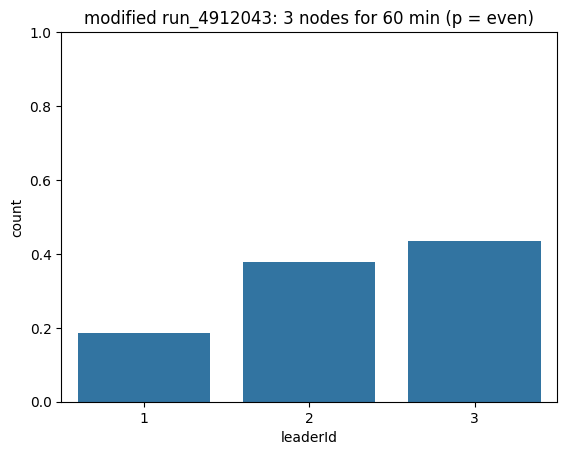

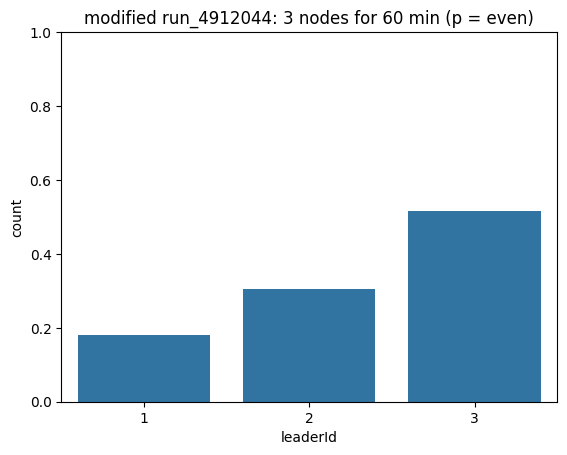

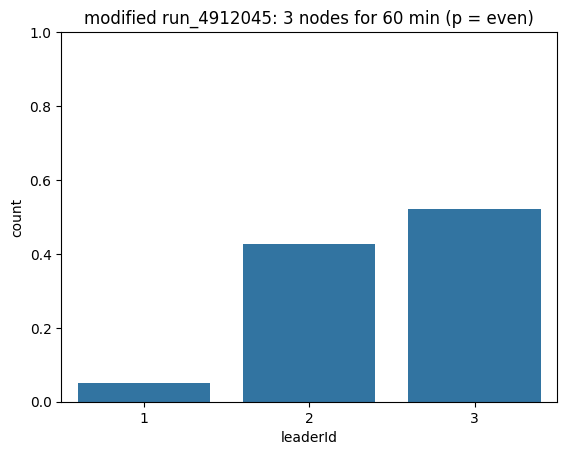

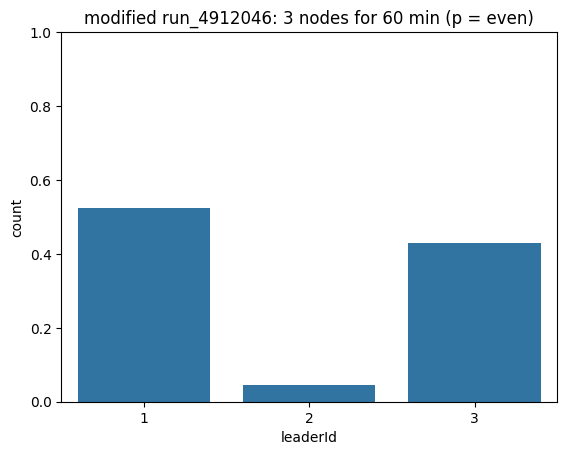

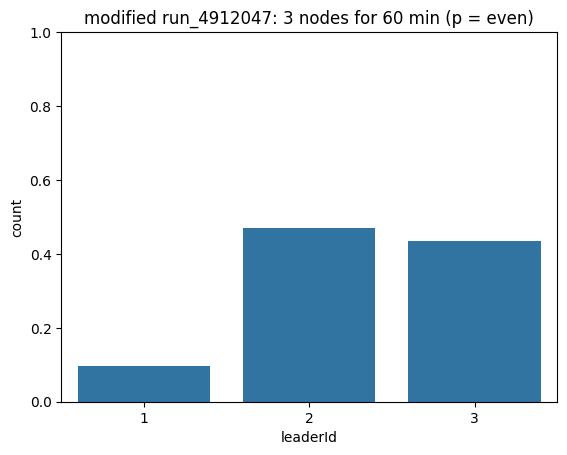

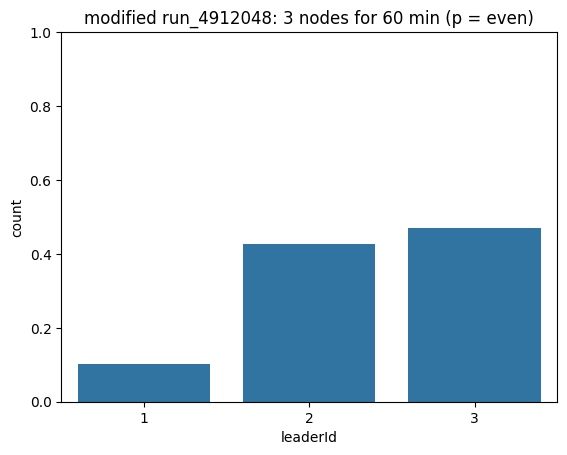

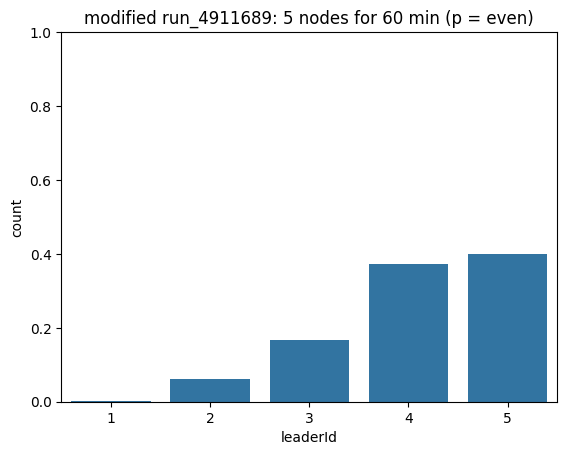

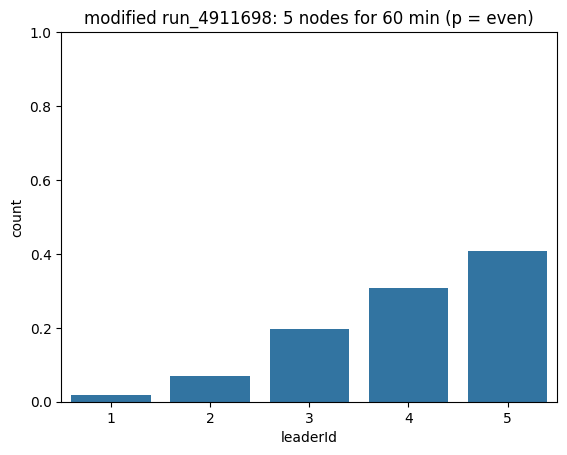

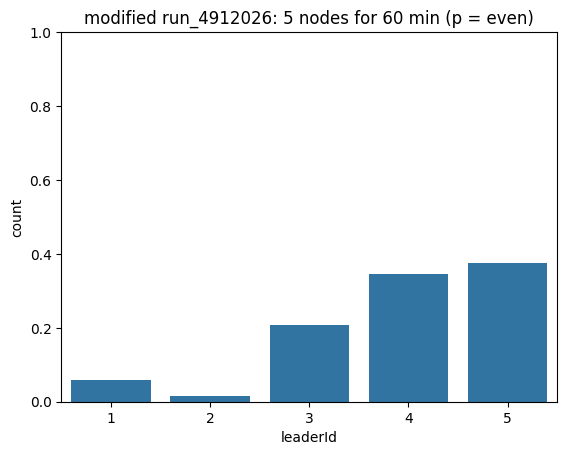

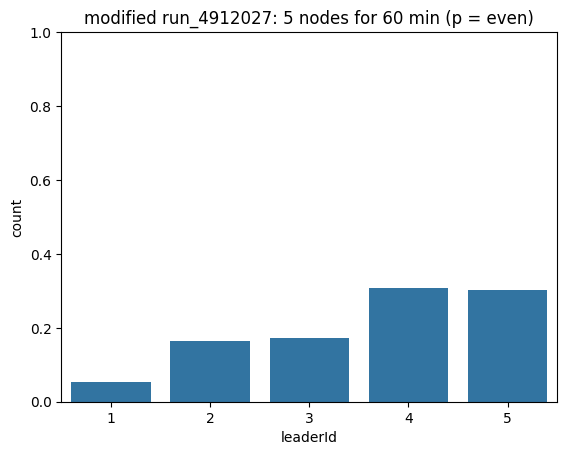

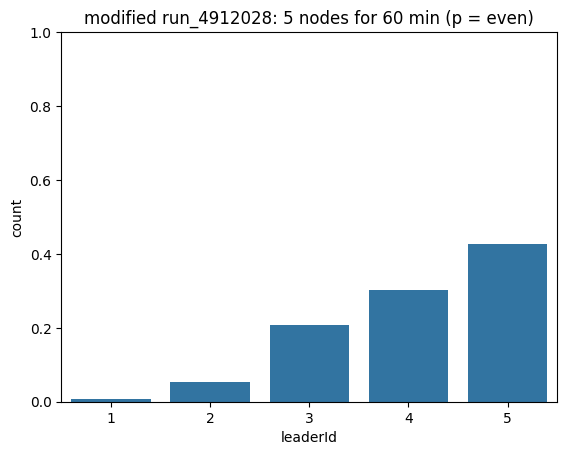

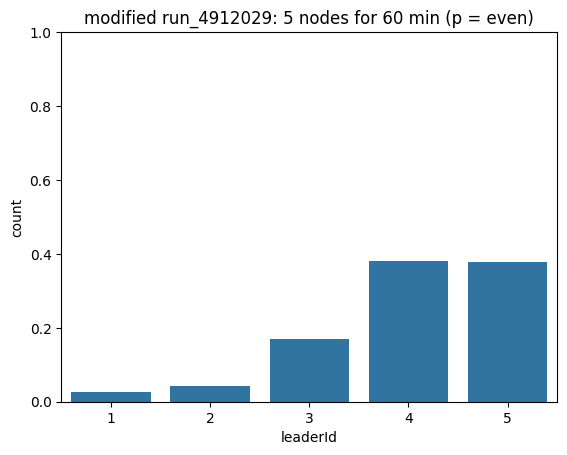

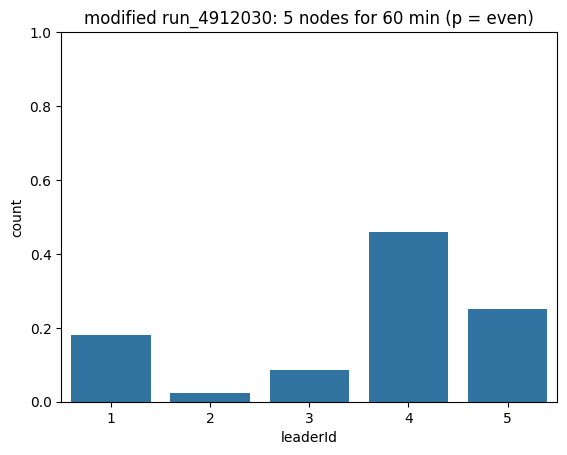

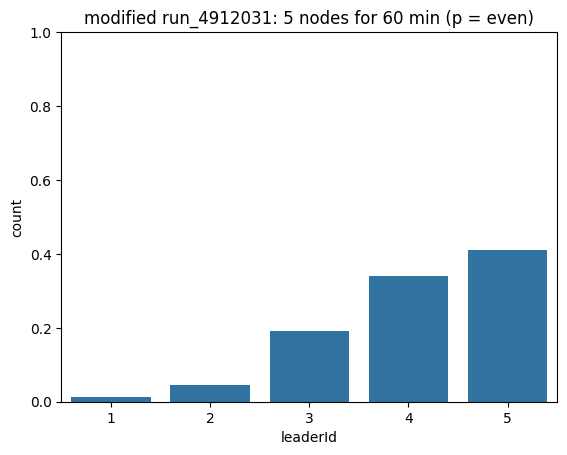

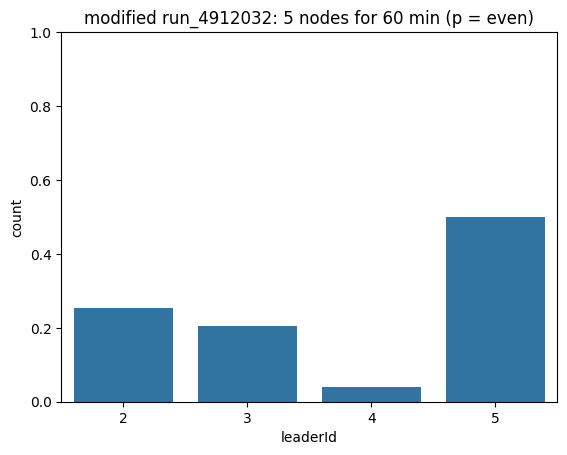

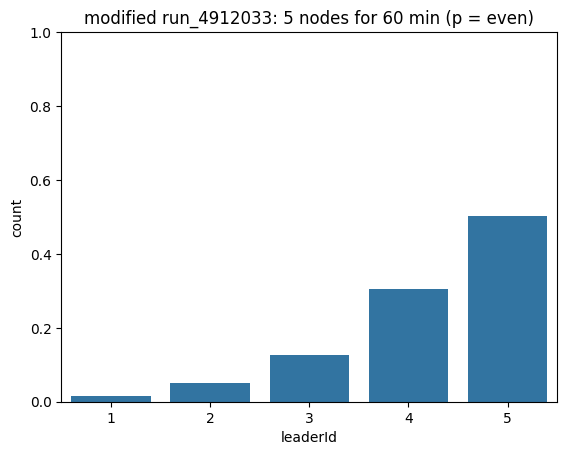

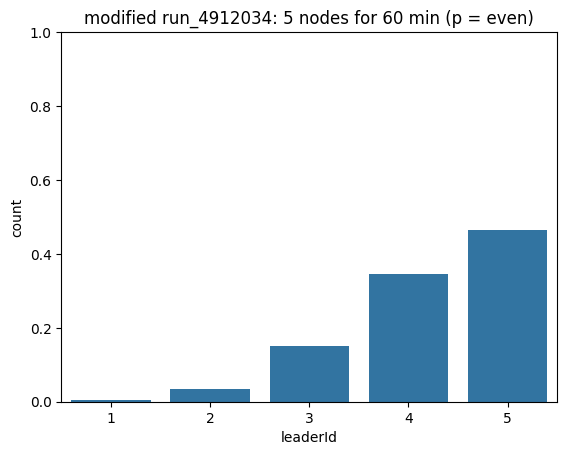

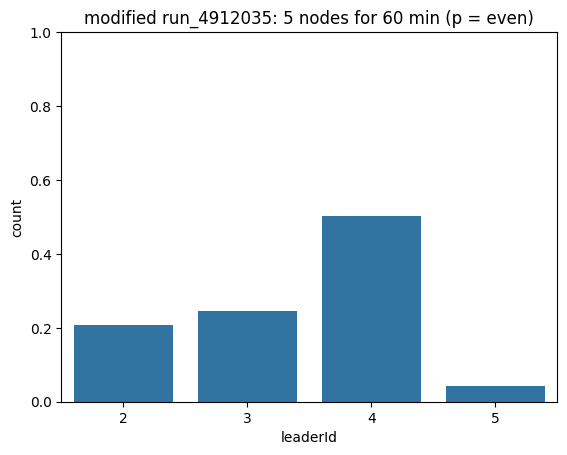

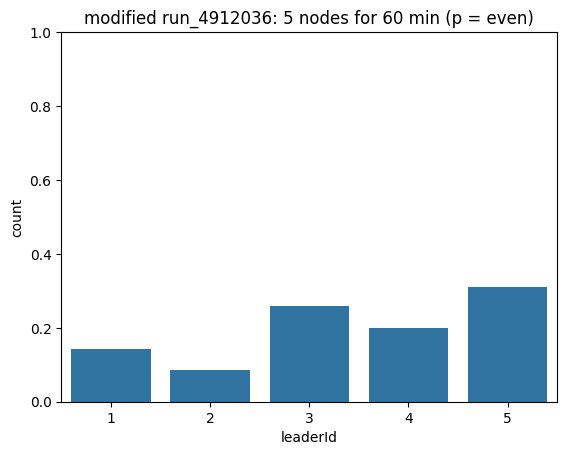

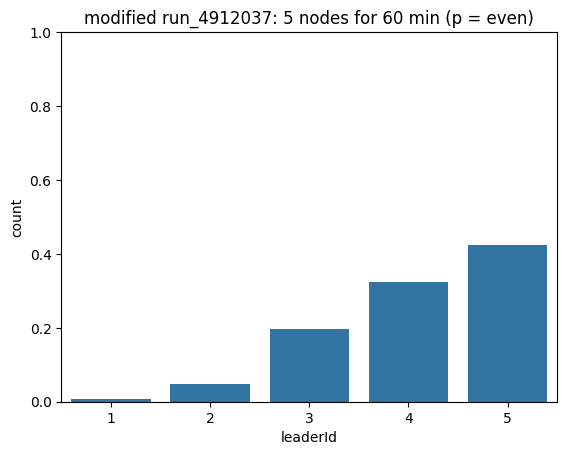

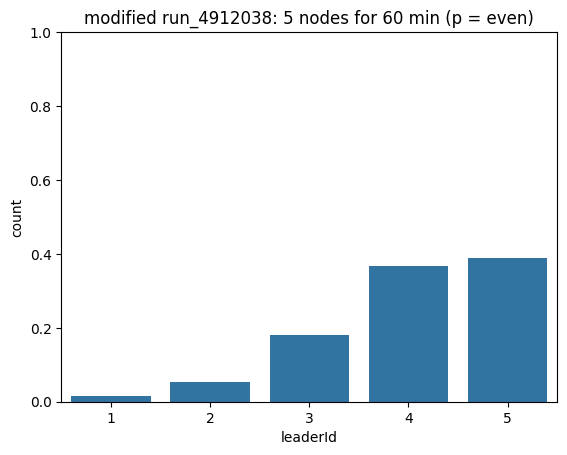

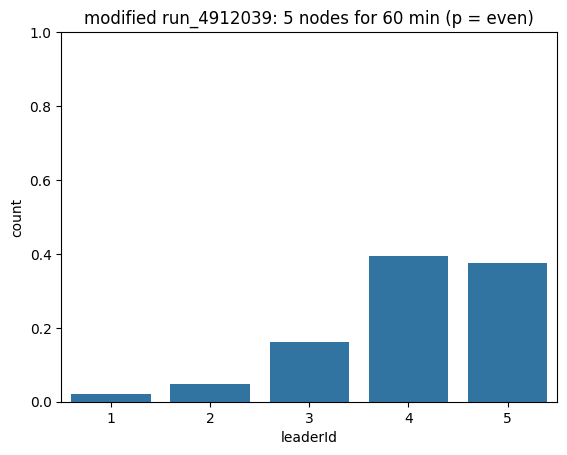

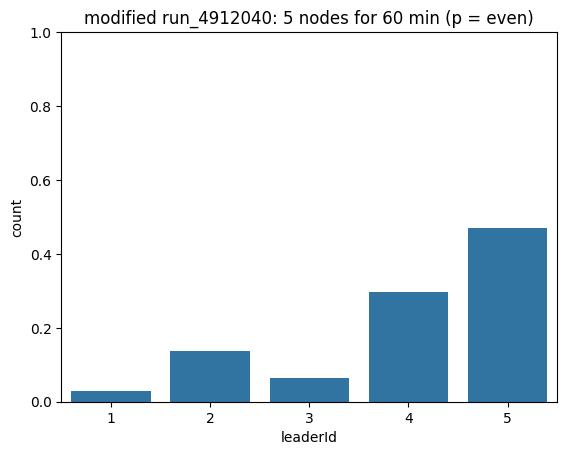

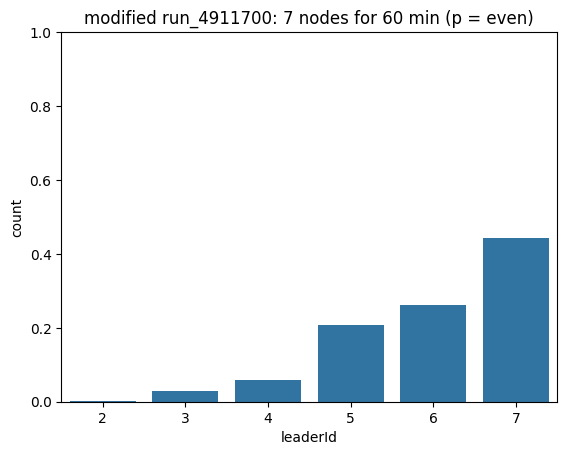

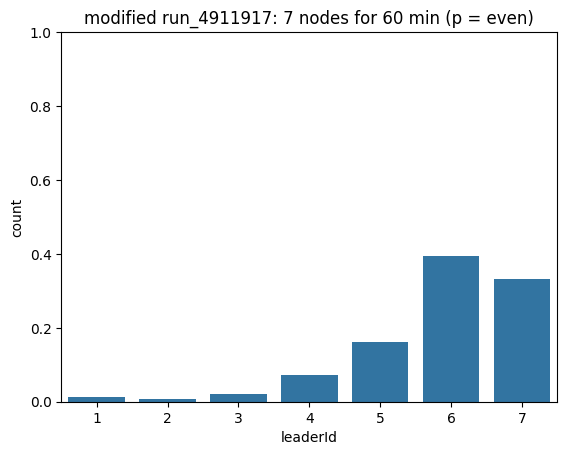

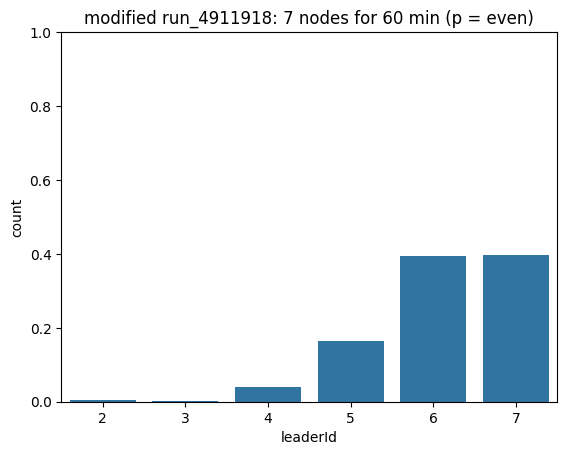

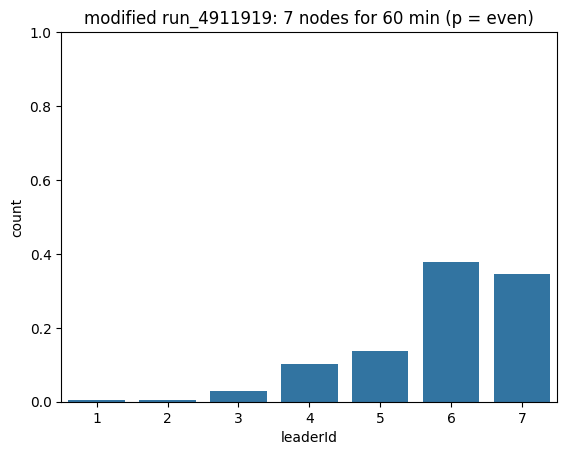

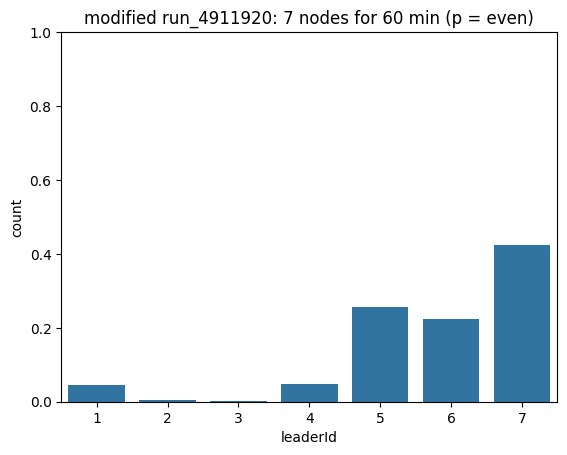

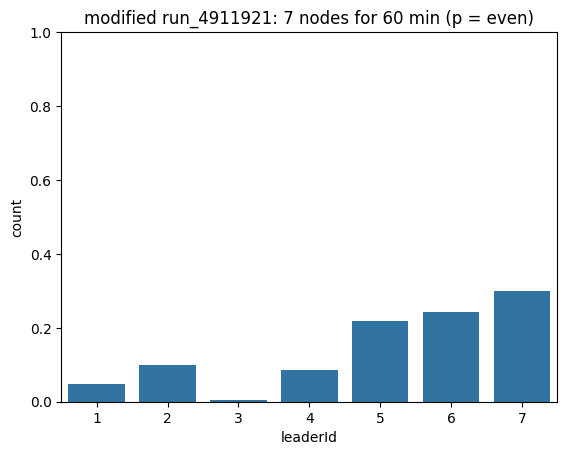

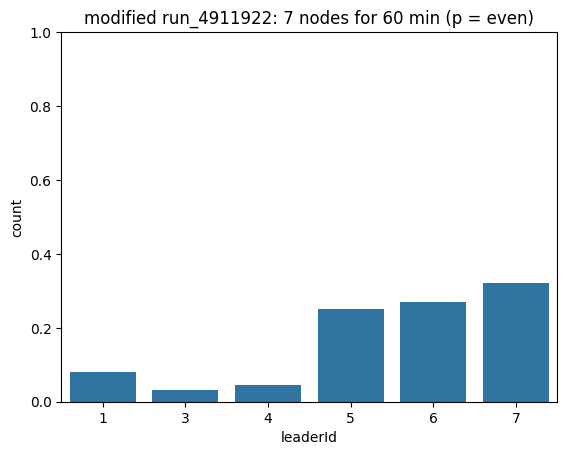

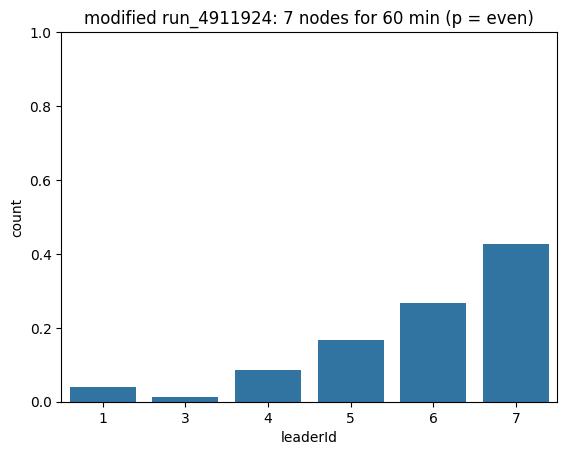

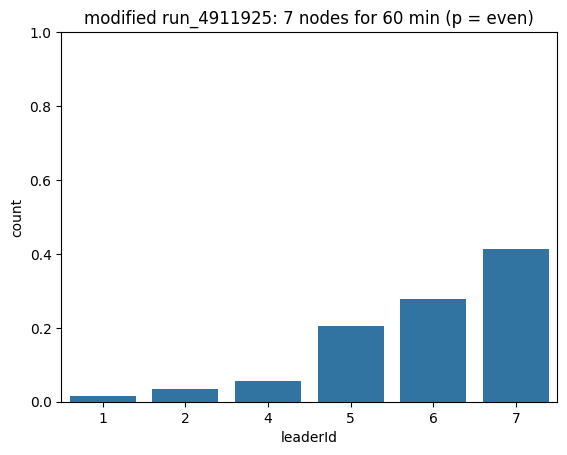

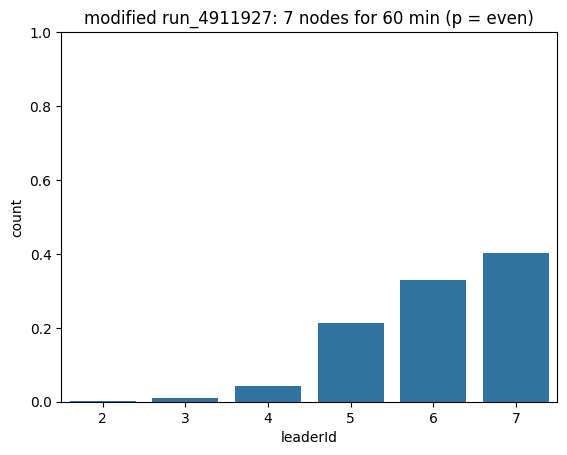

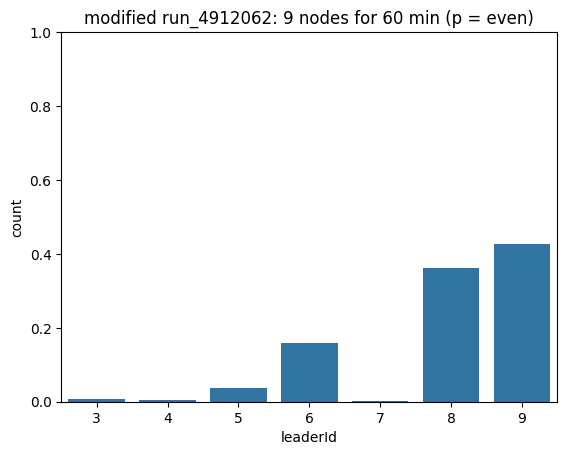

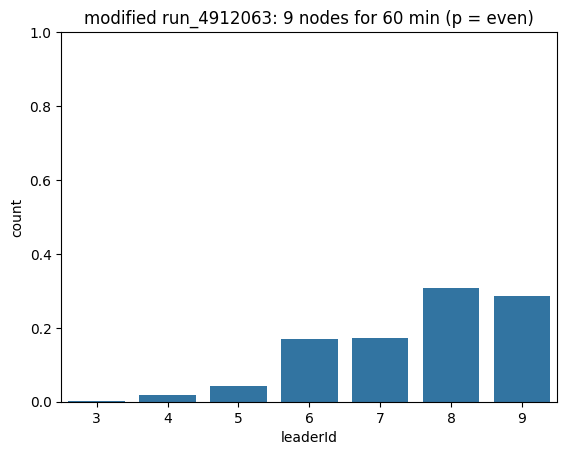

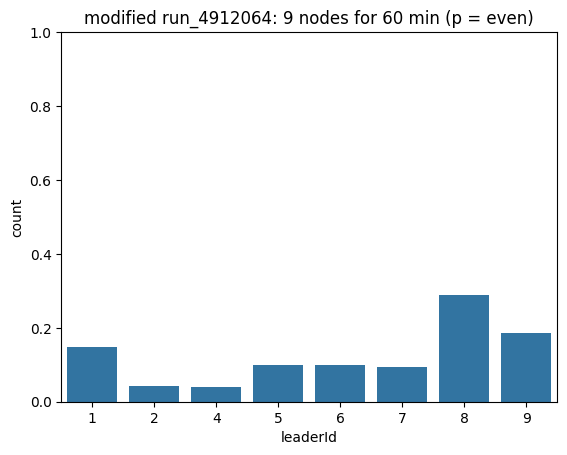

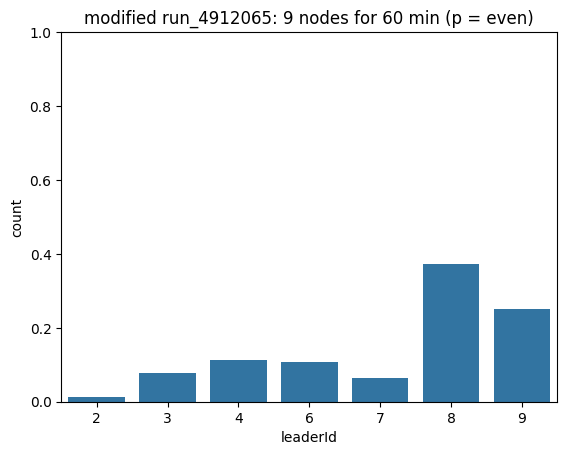

In [124]:
for file in find_all_csvs("../bench_data/"):
    algo = get_algorithm_type(file)
    nodes = get_node_count(file)
    minutes = get_duration_minutes(file)
    run = get_run_id(file)
    crash_probability = get_probability_type(file)
    plot_leader_commit_counts(open_csv(file), f"{algo} {run}: {nodes} nodes for {minutes} min (p = {crash_probability})")

# Performance

## Entry Throughput

In [125]:
def find_replicated_count(df : pd.DataFrame, node_count : int) -> int:
    entry_counts = df.groupby('serverId').size()
    committed = []
    for count in entry_counts:
        replicated_count = sum(map(lambda x: x >= count, entry_counts))
        if replicated_count >= node_count:
            committed.append(count)
    return max(committed) if len(committed) > 0 else 0

def find_committed_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_quorum_size(df))

def find_fully_replicated_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_node_count(df))

In [126]:
def split_logs_by(df : pd.DataFrame, column : str) -> pd.DataFrame:
    logs : list[pd.DataFrame] = []
    for val in df[column].unique():
        logs.append(df[df[column] == val])
    return logs


In [127]:
def find_replication_delays(df : pd.DataFrame, num_nodes : int):
    logs = split_logs_by(df, "serverId")

    last_replicated = find_replicated_count(df, num_nodes)
    
    delays = []

    for i in range(last_replicated):
        creation_time = min([log.iloc[i]["creationTime"] for log in logs if len(log) > i])
        storage_times = [log.iloc[i]["storageTime"] for log in logs if len(log) > i]
        
        if len(storage_times) < num_nodes:
            delays.append(None)
            print(f"None at {i}. Need {num_nodes}, have {len(storage_times)}")
        else:
            storage_times.sort()
            delays.append(storage_times[num_nodes - 1] - creation_time)
    return delays
        

In [128]:
import concurrent.futures

def process_data(paths : list[str]) -> pd.DataFrame:
   unprocessed_paths = []
   unprocessed_paths = paths
   existing_df = None

   algorithms = []
   node_counts = []
   durations_minutes = []
   run_ids = []
   dataframes = []
   full_replication_delays = []
   commit_delays = []
   committed_counts = []
   fully_replicated_counts = []
   committed_rates = []
   fully_replicated_rates = []
   longest_logs = []
   crash_probabilities = []


   for file in tqdm(unprocessed_paths):
      df = open_csv(file)

      algorithms.append(get_algorithm_type(file))
      node_counts.append(get_node_count(file))
      durations_minutes.append(get_duration_minutes(file))
      run_ids.append(get_run_id(file))
      dataframes.append(df)
      crash_probabilities.append(get_probability_type(file))
      commit_delays.append(find_replication_delays(df, find_quorum_size(df)))
      committed_counts.append(find_committed_count(df))
      fully_replicated_counts.append(find_fully_replicated_count(df))

      fully_replicated_rates = np.array(fully_replicated_counts) / RUNTIME_SECONDS
      committed_rates = np.array(committed_counts) / RUNTIME_SECONDS

   columns = {"path": paths, 
            "algorithm": algorithms, 
            "crashProbability": crash_probabilities,
            "nodeCount": node_counts, 
            "duration": durations_minutes, 
            "runId": run_ids, 
            "commitDelays": commit_delays,
            "fullReplicationCount": fully_replicated_counts, 
            "commitCount": committed_counts, 
            "fullReplicationRate": fully_replicated_rates,
            "commitRate": committed_rates,
            }
   new_entries = pd.DataFrame(columns)

   if existing_df is None:
      new_entries = new_entries.sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"])
      return new_entries
   else:
      result = pd.concat([existing_df, new_entries]).sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"]).reindex()
      return result


paths = find_all_csvs("../bench_data/")
DATA = process_data(paths)
display(DATA)


# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(process_data, [path]) for path in paths]
#     results = [f.result() for f in futures]
#     DATA_EVEN = pd.concat(results)


  0%|          | 0/204 [00:00<?, ?it/s]

100%|██████████| 204/204 [11:16<00:00,  3.31s/it]


path algorithm  \
0    c:\Users\cursa\Documents\University\MSc CS\The...   classic   
1    c:\Users\cursa\Documents\University\MSc CS\The...   classic   
2    c:\Users\cursa\Documents\University\MSc CS\The...   classic   
3    c:\Users\cursa\Documents\University\MSc CS\The...   classic   
4    c:\Users\cursa\Documents\University\MSc CS\The...   classic   
..                                                 ...       ...   
153  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
154  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
155  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
156  c:\Users\cursa\Documents\University\MSc CS\The...  modified   
157  c:\Users\cursa\Documents\University\MSc CS\The...  modified   

    crashProbability  nodeCount  duration        runId  \
0             biased          3        60  run_4912156   
1             biased          3        60  run_4912157   
2             biased          3        60  run_4912158   
3             biased          3        60  run_4912159   
4             biased          3        60  run_4912160   
..               ...        ...       ...          ...   
153             even         15        60  run_4912071   
154             even         15        60  run_4912124   
155             even         15        60  run_4912127   
156             even         15        60  run_4912152   
157             even         15        60  run_4912153   

                                          commitDelays  fullReplicationCount  \
0    [0.027445316314697266, 0.0022003650665283203, ...                 34233   
1    [0.04612588882446289, 0.01931929588317871, 0.0...                 26013   
2    [0.025681734085083008, 0.0023658275604248047, ...                 33572   
3    [0.02800130844116211, 0.0023620128631591797, 0...                 32926   
4    [0.06799817085266113, 0.03813672065734863, 0.0...                 25122   
..                                                 ...                   ...   
153  [0.05054450035095215, 0.013065338134765625, 0....                   116   
154  [0.045110464096069336, 0.012587785720825195, 0...                   154   
155  [0.1904313564300537, 0.1553490161895752, 0.103...                   112   
156  [0.045465707778930664, 0.008148431777954102, 0...                   130   
157  [0.0456695556640625, 0.009067535400390625, 0.0...                   132   

     commitCount  fullReplicationRate  commitRate  
0          34233             9.509167    9.509167  
1          26013             7.225833    7.225833  
2          33597             9.325556    9.332500  
3          32927             9.146111    9.146389  
4          25122             6.978333    6.978333  
..           ...                  ...         ...  
153         6395             0.032222    1.776389  
154         1079             0.042778    0.299722  
155          738             0.031111    0.205000  
156         4344             0.036111    1.206667  
157         5596             0.036667    1.554444  

[204 rows x 11 columns]

In [129]:
for file in FILES:
    df = open_csv(file)
    print(f"{file.split("bench_data", maxsplit=1)[1]}:\t committed {find_committed_count(df)}/{find_replicated_count(df, 1)},\t fully replicated {find_fully_replicated_count(df)}/{find_replicated_count(df, 1)}")

\biased\classic\3_nodes\60_minutes\run_4912156\data_run_4912156.csv:	 committed 34233/34233,	 fully replicated 34233/34233
\biased\classic\3_nodes\60_minutes\run_4912157\data_run_4912157.csv:	 committed 26013/26013,	 fully replicated 26013/26013
\biased\classic\3_nodes\60_minutes\run_4912158\data_run_4912158.csv:	 committed 33597/33597,	 fully replicated 33572/33597
\biased\classic\3_nodes\60_minutes\run_4912159\data_run_4912159.csv:	 committed 32927/32927,	 fully replicated 32926/32927
\biased\classic\3_nodes\60_minutes\run_4912160\data_run_4912160.csv:	 committed 25122/25122,	 fully replicated 25122/25122
\biased\classic\3_nodes\60_minutes\run_4912171\data_run_4912171.csv:	 committed 30944/30944,	 fully replicated 30944/30944
\biased\classic\3_nodes\60_minutes\run_4912172\data_run_4912172.csv:	 committed 32818/32818,	 fully replicated 32818/32818
\biased\classic\3_nodes\60_minutes\run_4912173\data_run_4912173.csv:	 committed 33126/33126,	 fully replicated 33086/33126
\biased\classic\

In [130]:
def get_col_from_all(data : pd.DataFrame, colname : str, algo : str = None, nodes : str = None, crashProb = None):
    filtered = data
    if not algo is None:
        filtered = filtered[filtered["algorithm"] == algo]
    if not crashProb is None:
        filtered = filtered[filtered["crashProbability"] == crashProb]
    if not nodes is None:
        filtered = filtered[filtered["nodeCount"] == nodes]
    
    if colname in ["fullReplicationDelays", "commitDelays"]:
        nested_lists = filtered[colname].tolist()
        return sum(nested_lists, start=[])
    else:
        return filtered[colname]

# Commit Latency Plots

In [234]:
def plot_commit_latencies(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)
                line_color = palette[ (idx_algo + idx_node + idx_prob) % len(palette) ]

                data = get_col_from_all(df, "commitDelays", algo, node, crash_prob)
                sns.ecdfplot(data, label=line_label, log_scale=True)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
                        
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")


    plt.axhline(y=0.5, color='r', linestyle=':')
    plt.axhline(y=0.05, color='r', linestyle='--')

        

    plt.title(f'{" ".join(title_elements)} commit latencies')
    plt.xlabel("Latency [milliseconds]")

    plt.xticks([10**exp for exp in range(-7, 3)])
    plt.yscale('log')
    plt.ylim(10**(-3), 1)

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

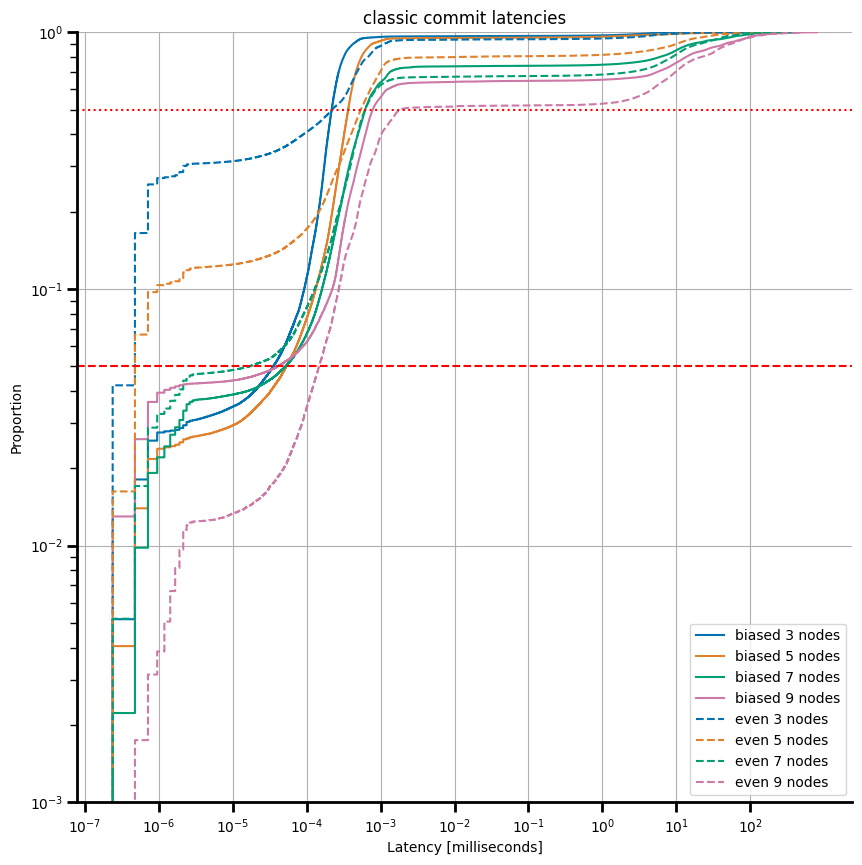

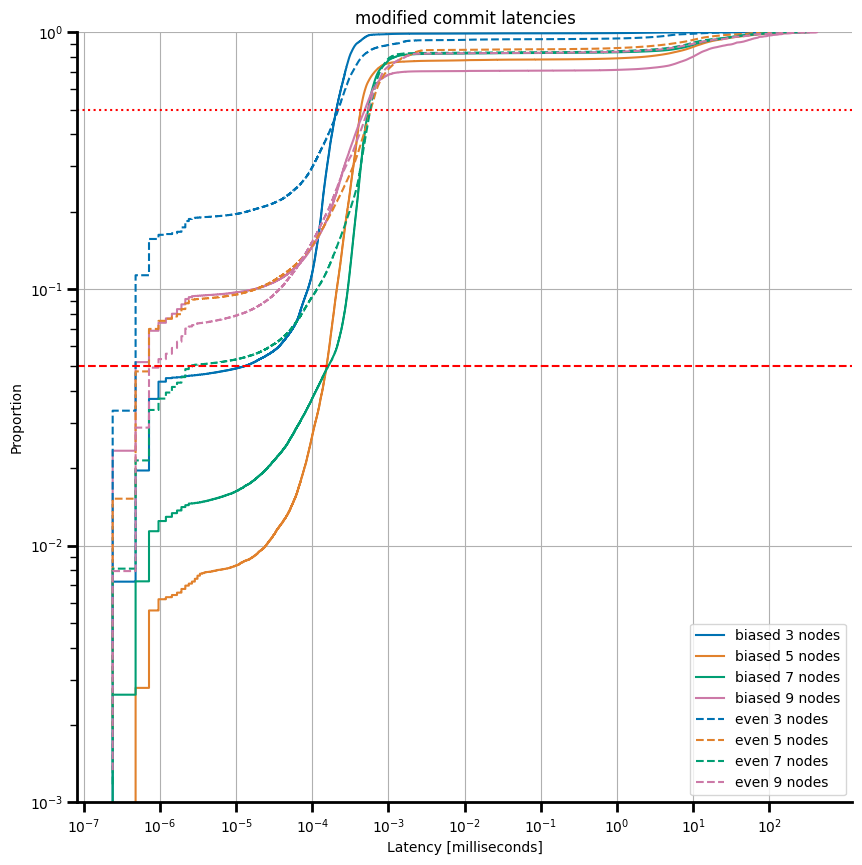

In [235]:
plot_commit_latencies(DATA, nodes=[3,5,7,9], algos=["classic"], probs=None, size=(10,10))
plot_commit_latencies(DATA, nodes=[3,5,7,9], algos=["modified"], probs=None, size=(10,10))


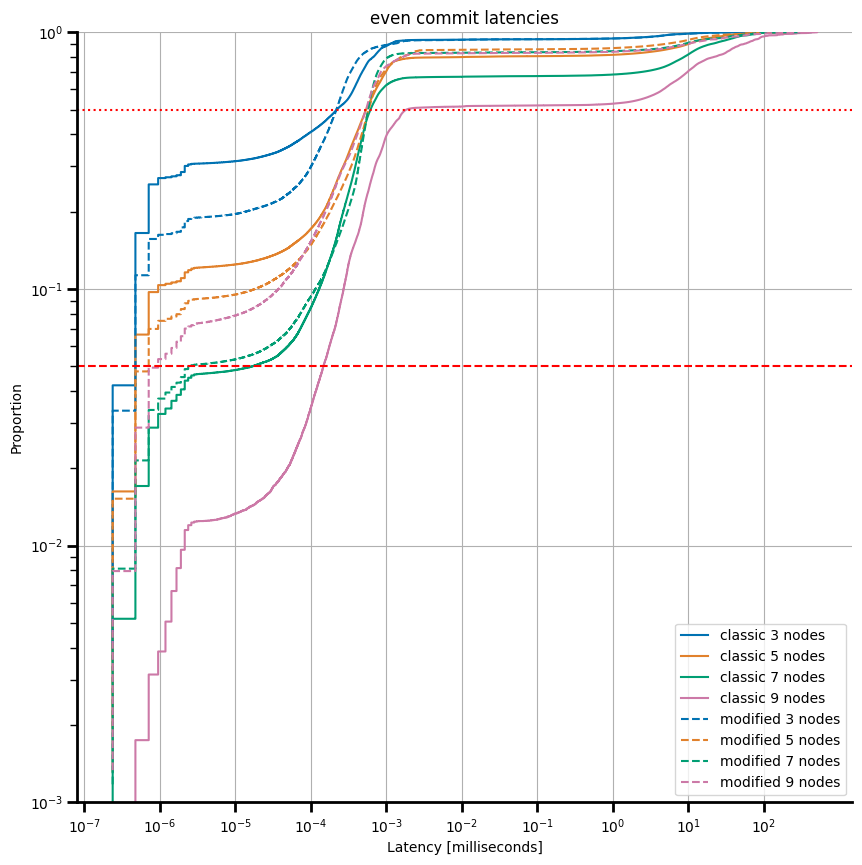

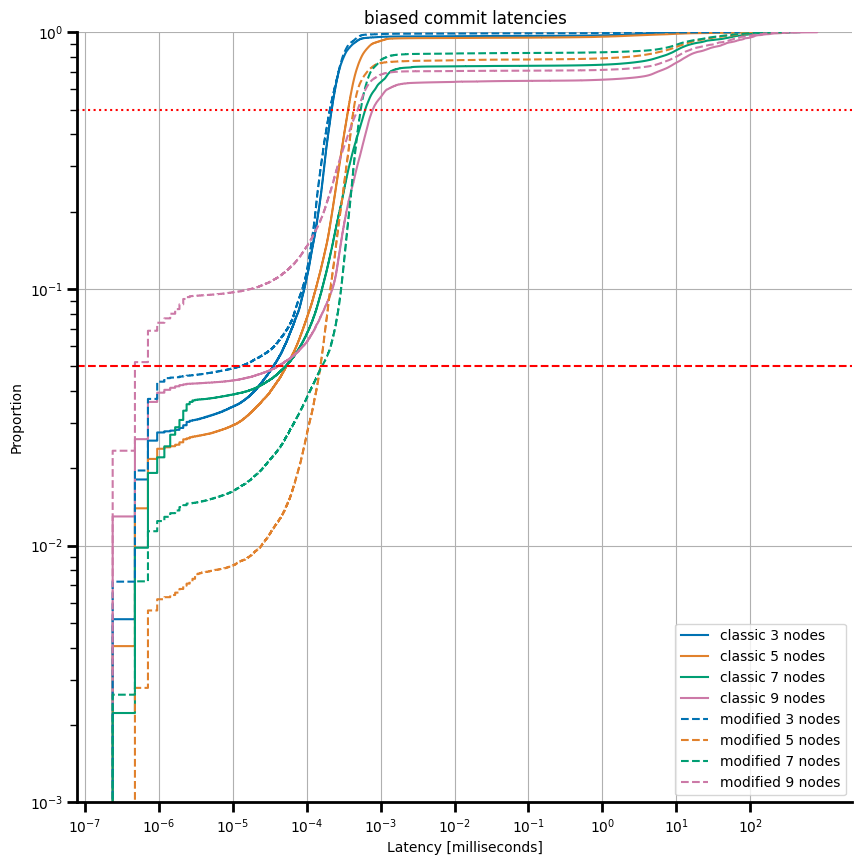

In [236]:
plot_commit_latencies(DATA, nodes=[3,5,7,9], algos=None, probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[3,5,7,9], algos=None, probs=['biased'], size=(10,10))

# Commit Rate Plots

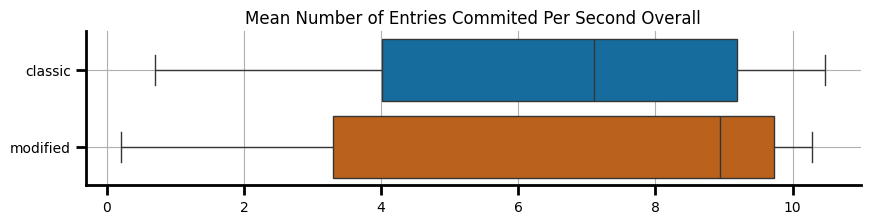

In [225]:
classic = get_col_from_all(DATA, "commitRate", algo="classic")
modified = get_col_from_all(DATA, "commitRate", algo="modified")

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

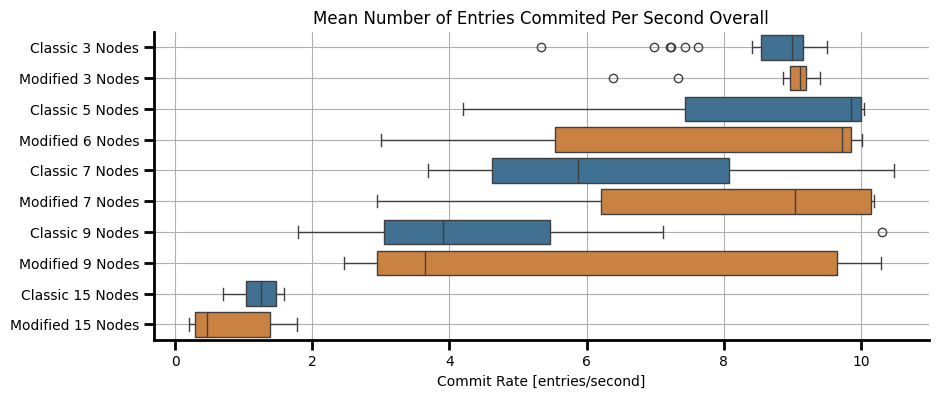

In [224]:
data = pd.DataFrame({
    "Classic 3 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=3),
    "Modified 3 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=3),
    "Classic 5 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=5),
    "Modified 6 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=5),
    "Classic 7 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=7),
    "Modified 7 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=7),
    "Classic 9 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=9),
    "Modified 9 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=9),
    "Classic 15 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=15),
    "Modified 15 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)
})

alternatic_palette = ['#3274A1', '#E1812C'] * 5

plt.figure(figsize=(10,4))
sns.boxplot(data, orient='h', palette=alternatic_palette)
plt.title("Mean Number of Entries Commited Per Second Overall")
plt.xlabel("Commit Rate [entries/second]")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

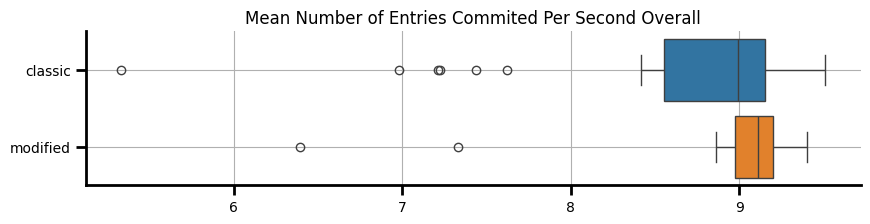

In [201]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=3)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=3)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

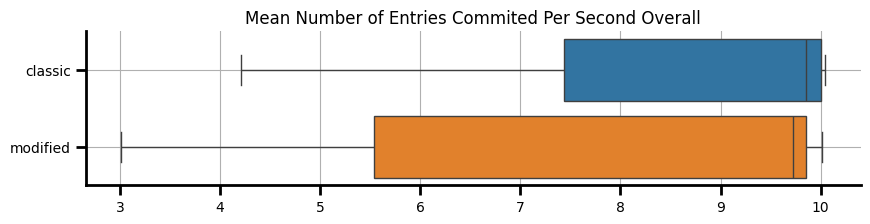

In [202]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=5)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=5)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

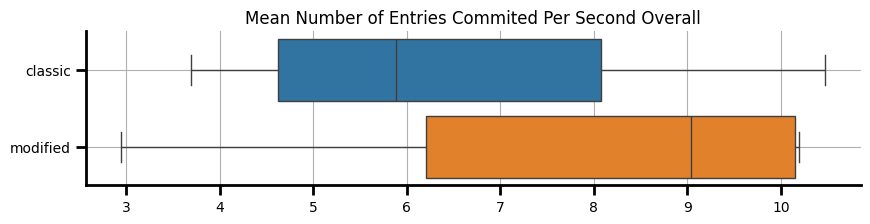

In [203]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=7)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=7)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

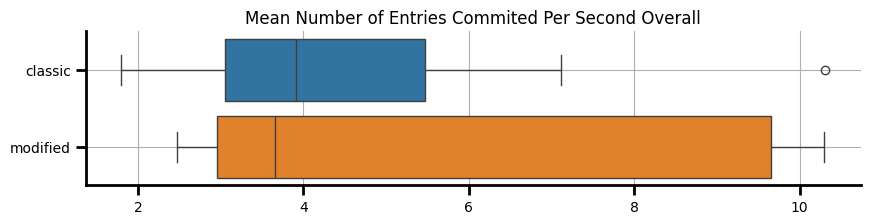

In [204]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=9)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=9)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

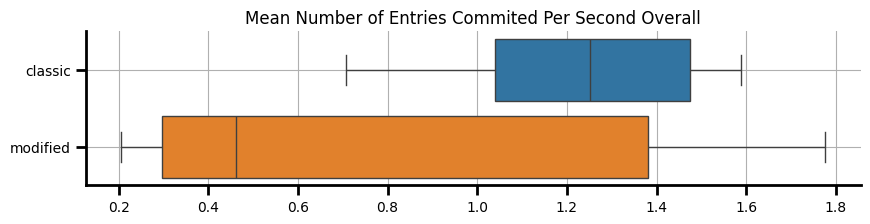

In [205]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=15)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

# Term Count Plots

In [237]:
def count_terms(file : str) -> tuple[int, int]:
    df = open_csv(file)
    terms_seen = df["term"].unique()
    num_productive_terms = len(terms_seen)
    num_empty_terms = terms_seen.max() - num_productive_terms
    return num_productive_terms, num_empty_terms


def get_Terms(file : str) -> tuple[list[int], list[int]]:
    df = open_csv(file)
    terms_seen = df["term"].unique().tolist()
    terms_missed = [term for term in range(max(terms_seen)) if not term in terms_seen]
    return terms_seen, terms_missed

In [ ]:
def plot_term_counts(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)
                line_color = palette[ (idx_algo + idx_node + idx_prob) % len(palette) ]

                data = get_col_from_all(df, "commitDelays", algo, node, crash_prob)
                sns.ecdfplot(data, label=line_label, log_scale=True)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
                        
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")


    plt.axhline(y=0.5, color='r', linestyle=':')
    plt.axhline(y=0.05, color='r', linestyle='--')

        

    plt.title(f'{" ".join(title_elements)} commit latencies')
    plt.xlabel("Latency [milliseconds]")

    plt.xticks([10**exp for exp in range(-7, 3)])
    plt.yscale('log')
    plt.ylim(10**(-3), 1)

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()